# <font color=orange>Amazon Fine Food Reviews Analysis</font>


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. <font color='orange'>Reading Data</font>

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 Order By Time LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] <font color=orange>Exploratory Data Analysis</font>

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

### <font color='orange'> Sorting according to Time</font>

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(35326, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

70.652

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(35325, 10)


1    31456
0     3869
Name: Score, dtype: int64

#  [3] <font color=orange>Preprocessing</font>

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I sent this plant to my sister when she moved into her new house for a new job.  I can't guarantee the fortune or luck, but my sister loves the Tree! It was her favorite house/job warming gift.  It's still really healthy now and has even grown some.  It was also delivered on the day after she moved in exactly as I asked.  Really good customer service and products, highly recommend.  Thanks again!
This is the best hot chocolate.  I first tried this in California and hoped that one day I could find it at a local market.  I was excited to find it at Amazon and now I get it shipped to me for gifts and for my husband and 

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I sent this plant to my sister when she moved into her new house for a new job.  I can't guarantee the fortune or luck, but my sister loves the Tree! It was her favorite house/job warming gift.  It's still really healthy now and has even grown some.  It was also delivered on the day after she moved in exactly as I asked.  Really good customer service and products, highly recommend.  Thanks again!
This is the best hot chocolate.  I first tried this in California and hoped that one day I could find it at a local market.  I was excited to find it at Amazon and now I get it shipped to me for gifts and for my husband and 

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is the best hot chocolate.  I first tried this in California and hoped that one day I could find it at a local market.  I was excited to find it at Amazon and now I get it shipped to me for gifts and for my husband and myself.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is the best hot chocolate I first tried this in California and hoped that one day I could find it at a local market I was excited to find it at Amazon and now I get it shipped to me for gifts and for my husband and myself 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 35325/35325 [00:20<00:00, 1721.98it/s]


In [23]:
preprocessed_reviews[1500]

'best hot chocolate first tried california hoped one day could find local market excited find amazon get shipped gifts husband'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similartly you can do preprocessing for review summary also.

# [4] <font color=orange>Featurization</font>

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaah', 'aaaaah', 'aaah', 'aaahs', 'aachen', 'aadp']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (35325, 36097)
the number of unique words  36097


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (35325, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['abandon', 'abdominal', 'ability', 'able', 'able buy', 'able drink', 'able eat', 'able enjoy', 'able find', 'able get']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (35325, 19674)
the number of unique words including both unigrams and bigrams  19674


## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [29]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.8070776462554932), ('amazing', 0.8031741380691528), ('excellent', 0.7961685061454773), ('wonderful', 0.7906148433685303), ('terrific', 0.7878305912017822), ('fantastic', 0.768135666847229), ('awesome', 0.7531514167785645), ('perfect', 0.7362741231918335), ('delicious', 0.6822821497917175), ('fabulous', 0.6743587851524353)]
[('greatest', 0.8298395872116089), ('best', 0.7968494892120361), ('nicest', 0.7679977416992188), ('tastiest', 0.7432138323783875), ('closest', 0.7196944355964661), ('sweetest', 0.7077778577804565), ('disgusting', 0.705847978591919), ('honestly', 0.6918936371803284), ('coolest', 0.6877126693725586), ('truer', 0.6701781749725342)]


In [30]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  11601
sample words  ['witty', 'little', 'book', 'makes', 'son', 'laugh', 'loud', 'car', 'driving', 'along', 'always', 'sing', 'learned', 'india', 'roses', 'love', 'new', 'words', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'remember', 'seeing', 'show', 'television', 'years', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirty', 'something', 'used', 'series', 'books', 'songs', 'student', 'teaching', 'turned', 'whole', 'school', 'purchasing', 'cd', 'children']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [31]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 35325/35325 [01:26<00:00, 410.57it/s]

35325
50


#### [4.4.1.2] TFIDF weighted W2v

In [32]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [33]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 35325/35325 [13:49<00:00, 42.59it/s]


# [5] <font color=orange>Assignment 5: Apply Logistic Regression</font>

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] <font color='orange'>Logistic Regression on BOW</font>,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [34]:
# Please write all the code with proper documentation

In [35]:
#hiding all the warnings
warnings.filterwarnings('ignore')

# Breaking the data into train and test


X = preprocessed_reviews
y = final['Score']
data=pd.DataFrame(preprocessed_reviews,columns=['review'])
data['score']=final['Score']
X_train, X_test= np.split(data, [int(.67 *len(X))])

X_train1=X_train
X_test1=X_test
print('length of X_train:',len(X_train),'length of X_test:',len(X_test))


length of X_train: 23667 length of X_test: 11658


In [36]:
#BoW

count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train['review'])
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(X_train['review'])
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

final_test=count_vect.transform(X_test['review'])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaah', 'aaaaah', 'aaah', 'aafco', 'aagh', 'aahing']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (23667, 30256)
the number of unique words  30256


In [37]:
# Shape of train and test data
print("X_train shape: {0} ".format(len(X_train)))
print("X_test shape:  {0} ".format(len(X_test)))

train_per=len(X_train)/len(X)*100
test_per=len(X_test)/len(X)*100
import math
print("\nPercentage of data in Train : {0:.1f} % and Test :{1:.1f} % ".format(train_per,test_per))

X_train shape: 23667 
X_test shape:  11658 

Percentage of data in Train : 67.0 % and Test :33.0 % 


In [38]:
from sklearn.preprocessing import StandardScaler
stdslr=StandardScaler(with_mean=False)
final_cnt=stdslr.fit_transform(final_counts)
final_tst=stdslr.fit_transform(final_test)

In [39]:
X_train=final_cnt
X_test=final_tst

y_train, y_test= np.split(y, [int(.67 *len(y))])
y_train1=y_train
y_test1=y_test
print("y_train shape: {0} ".format(len(y_train)))
print("y_test shape:  {0} ".format(len(y_test)))

y_train shape: 23667 
y_test shape:  11658 


## k-fold Cross Validation

### <font color='green'>With Class Weight Balanced</font>

In [42]:
# applying logistic regression 
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
cv_list=[]
# alpha_list=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
alpha_list=[10 ** x for x in range(-5, 5)]
for alp in tqdm(alpha_list):
    clf = LogisticRegression(penalty='l1',C=alp,class_weight='balanced')  
    scores=cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc') # 5 fold cross validation
    cv_list.append(scores.mean())

100%|██████████| 10/10 [00:14<00:00,  1.92s/it]


In [43]:
# optimal alpha
print(cv_list)
opt_alpha=cv_list.index(max(cv_list))
opt_alpha=math.pow(10,opt_alpha)*math.pow(10,-5)
print("Maximum auc is: ",max(cv_list),"for alpha=",opt_alpha)

[0.5, 0.5, 0.8006672728406891, 0.9165581700144425, 0.9064256741291683, 0.8864498886279071, 0.8719719004744455, 0.8594366999027898, 0.8362068151938005, 0.825145732279533]
Maximum auc is:  0.9165581700144425 for alpha= 0.01


In [44]:
# applying logistic regression 
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
cv_list=[]
# alpha_list=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
alpha_list=[10 ** x for x in range(-5, 5)]
for alp in tqdm(alpha_list):
    clf = LogisticRegression(penalty='l1',C=alp) 
    scores=cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc') # 5 fold cross validation
    cv_list.append(scores.mean())

100%|██████████| 10/10 [01:42<00:00,  5.29s/it]


In [45]:
# optimal alpha
print(cv_list)
opt_alpha=cv_list.index(max(cv_list))
opt_alpha=math.pow(10,opt_alpha)*math.pow(10,-5)
print("Maximum auc is: ",max(cv_list),"for alpha=",opt_alpha)

[0.5, 0.5, 0.5911332388247973, 0.9083142688567335, 0.913163472257669, 0.8913619119299099, 0.876309411001808, 0.8617811959002829, 0.8377201952109367, 0.8243333228937836]
Maximum auc is:  0.913163472257669 for alpha= 0.1


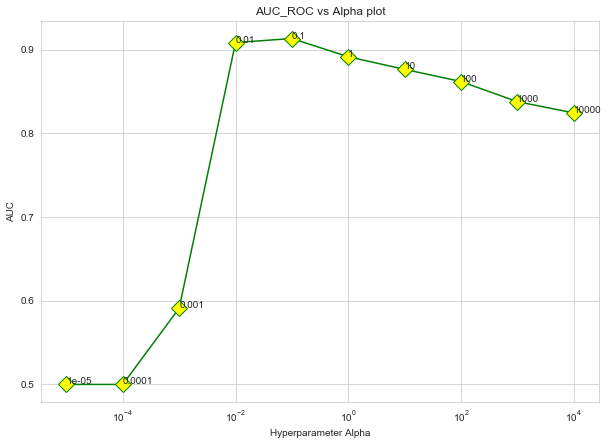

In [46]:
# plot of alpha vs auc_roc
plt.figure(figsize = (10,7))

sns.set_style("whitegrid");

plt.plot(alpha_list, cv_list, color='green',  marker='D',markerfacecolor='yellow', markersize=12)
ind=0
for val in alpha_list:
    plt.annotate('%s' % val,xy=(val,cv_list[ind]),xycoords='data')
    ind=ind+1
plt.xscale('log')
plt.title("AUC_ROC vs Alpha plot")
plt.xlabel('Hyperparameter Alpha')
plt.ylabel('AUC')
plt.show()

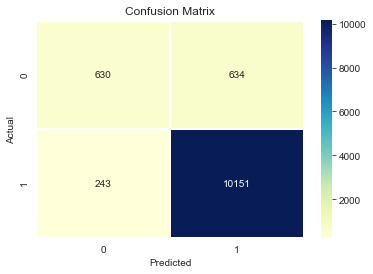

In [47]:
# print(metrics.confusion_matrix(y_test, predicted))

import seaborn as sb
from sklearn.metrics import confusion_matrix
log_optimal = LogisticRegression(penalty='l1',C=opt_alpha) 
log_optimal.fit(X_train, y_train)

conf_matrix = confusion_matrix(y_test,log_optimal.predict(X_test))
df_cmatrix = pd.DataFrame(conf_matrix) #, columns=['Negative', 'Positive'])
sb.heatmap(df_cmatrix, annot=True, fmt='d',cmap="YlGnBu", linewidths=1.4)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## AUC CURVE

In [48]:

# calculating train_auc
from sklearn.metrics import roc_auc_score

cv_list=[]

train_auc_list=[]

alpha_list=[10 ** x for x in range(-5, 5)]
for alp in tqdm(alpha_list):
    clf = LogisticRegression(penalty='l1',C=alp)
    clf.fit(X_train,y_train)
    probs = clf.predict_proba(X_train)
    probs = probs[:,1]
    train_auc = roc_auc_score(y_train, probs)
    train_auc_list.append(train_auc)

100%|██████████| 10/10 [00:03<00:00,  2.32it/s]


In [49]:

# calculating test_auc
from sklearn.metrics import roc_auc_score


cv_list=[]

test_auc_list=[]

alpha_list=[10 ** x for x in range(-5, 5)]
for alp in tqdm(alpha_list):
    clf = LogisticRegression(penalty='l1',C=alp)
    clf.fit(X_train,y_train)
    probs = clf.predict_proba(X_test)
    probs = probs[:,1]
    test_auc = roc_auc_score(y_test, probs)
    test_auc_list.append(test_auc)


100%|██████████| 10/10 [00:03<00:00,  2.37it/s]


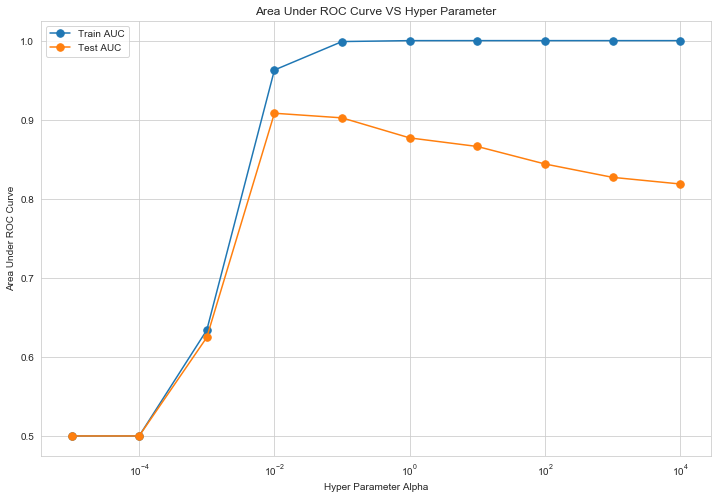

In [50]:

plt.figure(figsize = (12,8))
plt.plot(alpha_list, train_auc_list, marker='.',label="Train AUC",markersize=15)
plt.plot(alpha_list, test_auc_list, marker='.',label="Test AUC",markersize=15)

plt.xscale('log')

plt.legend()
plt.xlabel("Hyper Parameter Alpha")
plt.ylabel("Area Under ROC Curve")
plt.title("Area Under ROC Curve VS Hyper Parameter")
plt.show()

In [51]:
lr_optimal=LogisticRegression(penalty='l1',C=opt_alpha,max_iter=1000)
lr_optimal.fit(X_train,y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Train AUC: 0.998818
Test AUC: 0.902404


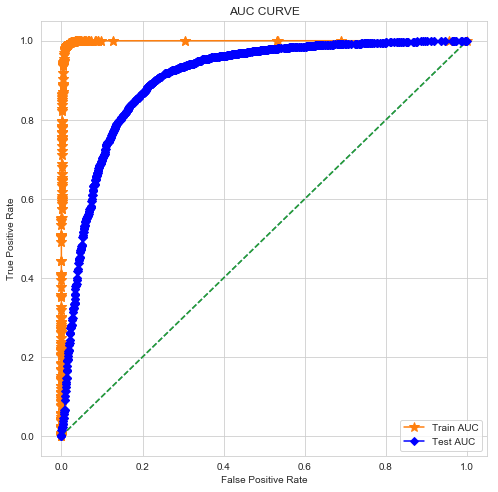

In [52]:

from matplotlib import pyplot
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

plt.figure(figsize = (8,8))
# predict probabilities
probs = lr_optimal.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
train_auc = roc_auc_score(y_train, probs)
print('Train AUC: %f' % train_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_train, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='*',label="Train AUC",markersize=10)


# predict probabilities
probs = lr_optimal.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
test_auc = roc_auc_score(y_test, probs)
print('Test AUC: %f' % test_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='D',color='blue',label="Test AUC",markersize=5)

plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC CURVE")

# show the plot
pyplot.show()




## Conclusion

In [53]:

bow_brute_par1=opt_alpha
bow_brute_auc1=np.round(test_auc,4)
print("Vectorizer: BOW \t Model: Logistic Regression")
print("Best Hyper parameter: ",bow_brute_par1)
print("AUC: ",bow_brute_auc1)


Vectorizer: BOW 	 Model: Logistic Regression
Best Hyper parameter:  0.1
AUC:  0.9024


#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [54]:
# Please write all the code with proper documentation

In [55]:
# https://machinelearningmastery.com/sparse-matrices-for-machine-learning/

# dense to sparse
from numpy import array
from scipy.sparse import csr_matrix
from numpy import array
from numpy import count_nonzero


In [56]:
# applying logistic regression using L1 regularization
clf = LogisticRegression(penalty='l1',C=opt_alpha)
clf.fit(X_train,y_train)

sparsity = 1.0 - (count_nonzero(clf.coef_))/X_train.size

print("----- Sparsity on Train with L1 regularization -----")
print('Sparsity on alpha :',opt_alpha,' is :',sparsity)

----- Sparsity on Train with L1 regularization -----
Sparsity on alpha : 0.1  is : 0.9940620158687745


In [57]:
# applying logistic regression using L1 regularization
clf = LogisticRegression(penalty='l2',C=opt_alpha)
clf.fit(X_train,y_train)

sparsity = 1.0 - (count_nonzero(clf.coef_))/X_train.size

print("----- Sparsity with L2 regularization -----")
print('Sparsity on alpha :',opt_alpha,' is :',sparsity)

----- Sparsity with L2 regularization -----
Sparsity on alpha : 0.1  is : 0.958111529989658


### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

In [58]:
words=count_vect.get_feature_names()
clf = LogisticRegression(penalty='l1',C=opt_alpha)
clf.fit(X_train,y_train)
coef=clf.coef_.tolist()[0]
coef=np.array(coef).T.tolist()
df_coef=pd.DataFrame({'words':words,'coef':coef})
df_coef1=df_coef.sort_values(['coef', 'words'], ascending=[0, 1])

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [59]:
print('Top 10 feature from Positive class')
print(df_coef1.head(10).to_string(index=False))

Top 10 feature from Positive class
     words      coef
     great  1.053550
      best  0.751006
 delicious  0.641295
      love  0.582450
      good  0.497789
 wonderful  0.481698
  favorite  0.456291
   perfect  0.433978
     loves  0.416629
      nice  0.415723


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [60]:
print('Top 10 feature from Negative class')        
print(df_coef1.tail(10).to_string(index=False))

Top 10 feature from Negative class
         words      coef
       coconut -0.206768
      terrible -0.223823
           bad -0.227012
      horrible -0.234278
         awful -0.237378
 unfortunately -0.252951
         bland -0.263270
  disappointed -0.299675
         worst -0.469430
           not -0.939134


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [61]:
# Please write all the code with proper documentation

In [62]:
#hiding all the warnings
warnings.filterwarnings('ignore')

# Breaking the data into train and test


X = preprocessed_reviews
y = final['Score']
data=pd.DataFrame(preprocessed_reviews,columns=['review'])
data['score']=final['Score']
X_train, X_test= np.split(data, [int(.67 *len(X))])

X_train1=X_train
X_test1=X_test
print('length of X_train:',len(X_train),'length of X_test:',len(X_test))


length of X_train: 23667 length of X_test: 11658


In [63]:
#BoW

count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train['review'])
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(X_train['review'])
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

final_test=count_vect.transform(X_test['review'])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaah', 'aaaaah', 'aaah', 'aafco', 'aagh', 'aahing']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (23667, 30256)
the number of unique words  30256


In [64]:
# Shape of train and test data
print("X_train shape: {0} ".format(len(X_train)))
print("X_test shape:  {0} ".format(len(X_test)))

train_per=len(X_train)/len(X)*100
test_per=len(X_test)/len(X)*100
import math
print("\nPercentage of data in Train : {0:.1f} % and Test :{1:.1f} % ".format(train_per,test_per))

X_train shape: 23667 
X_test shape:  11658 

Percentage of data in Train : 67.0 % and Test :33.0 % 


In [65]:
from sklearn.preprocessing import StandardScaler
stdslr=StandardScaler(with_mean=False)
final_cnt=stdslr.fit_transform(final_counts)
final_tst=stdslr.fit_transform(final_test)

In [66]:
X_train=final_cnt
X_test=final_tst

y_train, y_test= np.split(y, [int(.67 *len(y))])
y_train1=y_train
y_test1=y_test
print("y_train shape: {0} ".format(len(y_train)))
print("y_test shape:  {0} ".format(len(y_test)))

y_train shape: 23667 
y_test shape:  11658 


## k-fold Cross Validation

In [67]:
# applying logistic regression 
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
cv_list=[]
# alpha_list=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
alpha_list=[10 ** x for x in range(-5, 5)]
for alp in tqdm(alpha_list):
    clf = LogisticRegression(penalty='l2',C=alp)
    scores=cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc') # 5 fold cross validation
    cv_list.append(scores.mean())

100%|██████████| 10/10 [00:49<00:00,  6.85s/it]


In [68]:
# optimal alpha
print(cv_list)
opt_alpha=cv_list.index(max(cv_list))
opt_alpha=math.pow(10,opt_alpha)*math.pow(10,-5)
print("Maximum auc is: ",max(cv_list),"for alpha=",opt_alpha)

[0.6233983782486278, 0.7918035266917464, 0.8666880933353156, 0.8727039057707969, 0.85987766244695, 0.8478708333130689, 0.8402143753652785, 0.8301590578830739, 0.8200959888977843, 0.8191033249947035]
Maximum auc is:  0.8727039057707969 for alpha= 0.01


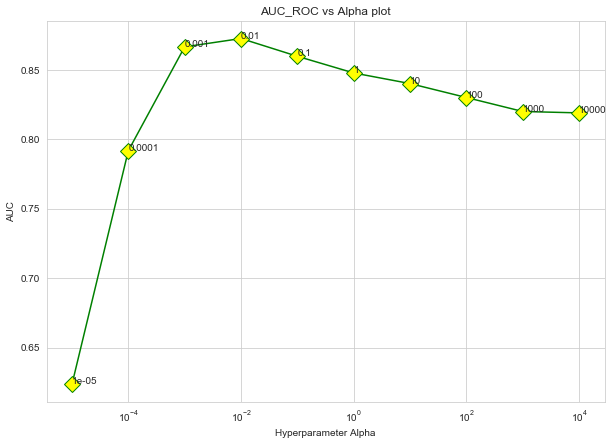

In [69]:
# plot of alpha vs auc_roc
plt.figure(figsize = (10,7))

sns.set_style("whitegrid");

plt.plot(alpha_list, cv_list, color='green',  marker='D',markerfacecolor='yellow', markersize=12)
ind=0
for val in alpha_list:
    plt.annotate('%s' % val,xy=(val,cv_list[ind]),xycoords='data')
    ind=ind+1
plt.xscale('log')
plt.title("AUC_ROC vs Alpha plot")
plt.xlabel('Hyperparameter Alpha')
plt.ylabel('AUC')
plt.show()

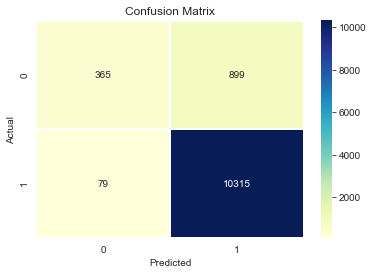

In [70]:
# print(metrics.confusion_matrix(y_test, predicted))

import seaborn as sb
from sklearn.metrics import confusion_matrix
log_optimal = LogisticRegression(penalty='l1',C=opt_alpha) 
log_optimal.fit(X_train, y_train)

conf_matrix = confusion_matrix(y_test,log_optimal.predict(X_test))
df_cmatrix = pd.DataFrame(conf_matrix) #, columns=['Negative', 'Positive'])
sb.heatmap(df_cmatrix, annot=True, fmt='d',cmap="YlGnBu", linewidths=1.4)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## AUC CURVE

In [71]:

# calculating train_auc
from sklearn.metrics import roc_auc_score

cv_list=[]

train_auc_list=[]

alpha_list=[10 ** x for x in range(-5, 5)]
for alp in tqdm(alpha_list):
    clf = LogisticRegression(penalty='l2',C=alp)
    clf.fit(X_train,y_train)
    probs = clf.predict_proba(X_train)
    probs = probs[:,1]
    train_auc = roc_auc_score(y_train, probs)
    train_auc_list.append(train_auc)

100%|██████████| 10/10 [00:13<00:00,  1.99s/it]


In [72]:

# calculating test_auc
from sklearn.metrics import roc_auc_score


cv_list=[]

test_auc_list=[]

alpha_list=[10 ** x for x in range(-5, 5)]
for alp in tqdm(alpha_list):
    clf = LogisticRegression(penalty='l2',C=alp)
    clf.fit(X_train,y_train)
    probs = clf.predict_proba(X_test)
    probs = probs[:,1]
    test_auc = roc_auc_score(y_test, probs)
    test_auc_list.append(test_auc)


100%|██████████| 10/10 [00:13<00:00,  2.05s/it]


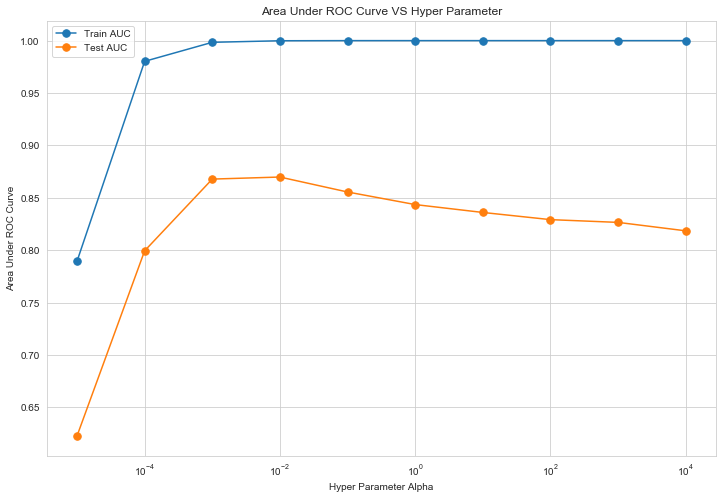

In [73]:

plt.figure(figsize = (12,8))
plt.plot(alpha_list, train_auc_list, marker='.',label="Train AUC",markersize=15)
plt.plot(alpha_list, test_auc_list, marker='.',label="Test AUC",markersize=15)

plt.xscale('log')

plt.legend()
plt.xlabel("Hyper Parameter Alpha")
plt.ylabel("Area Under ROC Curve")
plt.title("Area Under ROC Curve VS Hyper Parameter")
plt.show()

In [74]:
lr_optimal=LogisticRegression(penalty='l2',C=opt_alpha)
lr_optimal.fit(X_train,y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Train AUC: 0.999871
Test AUC: 0.869844


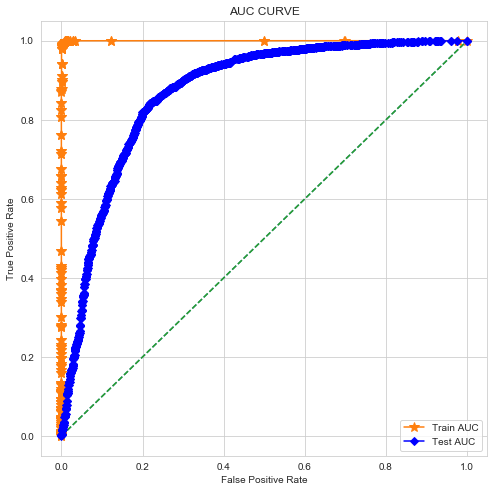

In [75]:

from matplotlib import pyplot
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

plt.figure(figsize = (8,8))
# predict probabilities
probs = lr_optimal.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
train_auc = roc_auc_score(y_train, probs)
print('Train AUC: %f' % train_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_train, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='*',label="Train AUC",markersize=10)


# predict probabilities
probs = lr_optimal.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
test_auc = roc_auc_score(y_test, probs)
print('Test AUC: %f' % test_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='D',color='blue',label="Test AUC",markersize=5)

plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC CURVE")

# show the plot
pyplot.show()




## Conclusion

In [76]:

bow_brute_par2=opt_alpha
bow_brute_auc2=np.round(test_auc,4)
print("Vectorizer: BOW \t Model: Logistic Regression(L2)")
print("Best Hyper parameter: ",bow_brute_par2)
print("AUC: ",bow_brute_auc2)


Vectorizer: BOW 	 Model: Logistic Regression(L2)
Best Hyper parameter:  0.01
AUC:  0.8698


In [77]:
words=count_vect.get_feature_names()
coef=clf.coef_.tolist()[0]
coef=np.array(coef).T.tolist()
df_coef=pd.DataFrame({'words':words,'coef':coef})
df_coef1=df_coef.sort_values(['coef', 'words'], ascending=[0, 1])

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [78]:
# Please write all the code with proper documentation

In [79]:
clf1=LogisticRegression(penalty='l2',C=opt_alpha)
clf1.fit(X_train,y_train)
coef1=clf1.coef_
# coef1=df_coef.values

noise=0.01 #adding small noise to weight

X_train_new=X_train
print('Type of X_train:',type(X_train_new))
X_train_new.data+=noise

clf2=LogisticRegression(penalty='l2',C=opt_alpha)
clf2.fit(X_train_new,y_train)
esp=math.pow(10,-6)
print(esp)

coef1=clf1.coef_[0]
coef2=clf2.coef_[0]


print(coef1)
print(coef1+esp)

coef1=coef1+ esp
coef2=coef2 + esp
diff_percentage=abs((coef1-coef2)/(coef1))*100
print("Percentage differece:",diff_percentage,"\n")

# calculating the percentiles
print('------ Percentile before adding noise ------ \n')
for i in range(0,11):
    print(i*10,'th percentile is :',np.percentile(coef1,i*10))

print()
# calculating the percentiles
print('------ Percentile after adding noise ------ \n')

for i in range(0,11):
    print(i*10,'th percentile is :',np.percentile(coef2,i*10))


Type of X_train: <class 'scipy.sparse.csr.csr_matrix'>
1e-06
[0.00920718 0.01515391 0.00433644 ... 0.00016849 0.01217148 0.00029715]
[0.00920818 0.01515491 0.00433744 ... 0.00016949 0.01217248 0.00029815]
Percentage differece: [0.09140952 0.00438106 0.25206992 ... 0.19576245 0.15928915 1.41880051] 

------ Percentile before adding noise ------ 

0 th percentile is : -0.40115996454953695
10 th percentile is : -0.01201851871945779
20 th percentile is : -0.00021452206101413982
30 th percentile is : 2.499678785650464e-06
40 th percentile is : 0.00013164075494480552
50 th percentile is : 0.0009117361343566209
60 th percentile is : 0.002483003187023477
70 th percentile is : 0.004929394291150909
80 th percentile is : 0.008695962889557946
90 th percentile is : 0.016242622619454854
100 th percentile is : 0.5837723424880757

------ Percentile after adding noise ------ 

0 th percentile is : -0.40095232964220173
10 th percentile is : -0.012026210640794156
20 th percentile is : -7.134424678599092e

In [80]:
# diff_per_sort=np.sort(diff_percentage,ascending)
# coef1=coef1[0]
# coef2=coef2[0]
diff_per_sort=abs((coef1-coef2)/(coef1))*100
# diff_per_sort=diff_percentage[0]
# diff_per_sort=-np.sort(-diff_per_sort)
# print(diff_per_sort)

thr=10
feat_change=[]
feat_name=[]
ind_list=[]
indx=0
dic={}
for val in diff_per_sort:
    if(val>thr):
        feat_change.append(val)
        ind_list.append(indx)
        dic.update({indx:val})
    indx+=1
print("Total number of weigts:",len(diff_per_sort))
print("Number of weights changed above threshold:",len(feat_change))

# ind_list=np.array(ind_list)
# ind_list_sorted=-np.sort(-ind_list)

# ind_list_sorted[200:250]

# https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
import operator

sorted_dic = sorted(dic.items(), key=operator.itemgetter(1))
# print("\n",sorted_dic[0:10])

print("\n------ Top 10 feature with changed after adding noise -----\n")
for i in range(10):
    print("Feature :",words[sorted_dic[i][0]])

Total number of weigts: 30256
Number of weights changed above threshold: 854

------ Top 10 feature with changed after adding noise -----

Feature : underground
Feature : accented
Feature : artfully
Feature : sweaty
Feature : bronchitis
Feature : explains
Feature : scattered
Feature : terminology
Feature : complaining
Feature : upsets


### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [81]:
print('Top 10 feature from Positive class')
print(df_coef1.head(10).to_string(index=False))

Top 10 feature from Positive class
     words      coef
     great  4.837540
      best  3.521542
      good  3.481054
      love  3.388008
 excellent  2.211386
      find  2.183399
     tasty  2.157037
      sure  1.804776
     loves  1.800440
    really  1.797269


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [82]:
print('Top 10 feature from Negative class')        
print(df_coef1.tail(10).to_string(index=False))

Top 10 feature from Negative class
    words      coef
     dont -1.442030
    stale -1.471512
    worth -1.481650
     name -1.498560
 cinnamon -1.562439
 probably -1.575549
    small -1.614003
     hard -1.639354
    worst -1.971976
      not -3.639606


## [5.2] <font color='orange'>Logistic Regression on TFIDF</font>,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [83]:
# Please write all the code with proper documentation

In [84]:
#hiding all the warnings
warnings.filterwarnings('ignore')

# Breaking the data into train and test


X = preprocessed_reviews
y = final['Score']
data=pd.DataFrame(preprocessed_reviews,columns=['review'])
data['score']=final['Score']
X_train, X_test= np.split(data, [int(.67 *len(X))])

X_train1=X_train
X_test1=X_test
print('length of X_train:',len(X_train),'length of X_test:',len(X_test))


length of X_train: 23667 length of X_test: 11658


In [85]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=5)
tf_idf_vect.fit(X_train['review'])
X_train_tfidf= tf_idf_vect.transform(X_train['review'])

X_test_tfidf=tf_idf_vect.transform(X_test['review'])

In [86]:
# Shape of train and test data
print("X_train shape: {0} ".format(len(X_train)))
print("X_test shape:  {0} ".format(len(X_test)))

train_per=len(X_train)/len(X)*100
test_per=len(X_test)/len(X)*100
import math
print("\nPercentage of data in Train : {0:.1f} % and Test :{1:.1f} % ".format(train_per,test_per))

X_train shape: 23667 
X_test shape:  11658 

Percentage of data in Train : 67.0 % and Test :33.0 % 


In [87]:
final_counts=X_train_tfidf
final_test=X_test_tfidf

y_train, y_test= np.split(y, [int(.67 *len(y))])
print("y_train shape: {0} ".format(len(y_train)))
print("y_test shape:  {0} ".format(len(y_test)))

y_train shape: 23667 
y_test shape:  11658 


In [88]:
from sklearn.preprocessing import StandardScaler
stdslr=StandardScaler(with_mean=False)
final_cnt=stdslr.fit_transform(final_counts)
final_tst=stdslr.fit_transform(final_test)

In [89]:
X_train=final_cnt
X_test=final_tst

y_train, y_test= np.split(y, [int(.67 *len(y))])
y_train1=y_train
y_test1=y_test
print("y_train shape: {0} ".format(len(y_train)))
print("y_test shape:  {0} ".format(len(y_test)))

y_train shape: 23667 
y_test shape:  11658 


## k-fold Cross Validation

In [90]:
# applying logistic regression 
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
cv_list=[]
# alpha_list=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
alpha_list=[10 ** x for x in range(-5, 5)]
for alp in tqdm(alpha_list):
    clf = LogisticRegression(penalty='l1',C=alp)
    scores=cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc') # 5 fold cross validation
    cv_list.append(scores.mean())

100%|██████████| 10/10 [00:17<00:00,  1.98s/it]


In [91]:
# optimal alpha
print(cv_list)
opt_alpha=cv_list.index(max(cv_list))
opt_alpha=math.pow(10,opt_alpha)*math.pow(10,-5)
print("Maximum auc is: ",max(cv_list),"for alpha=",opt_alpha)

[0.5, 0.5, 0.5936797118041678, 0.9224060024401721, 0.9243166101930462, 0.9207395097833082, 0.9208266625555547, 0.910467102525247, 0.8868891526306217, 0.8605819733859805]
Maximum auc is:  0.9243166101930462 for alpha= 0.1


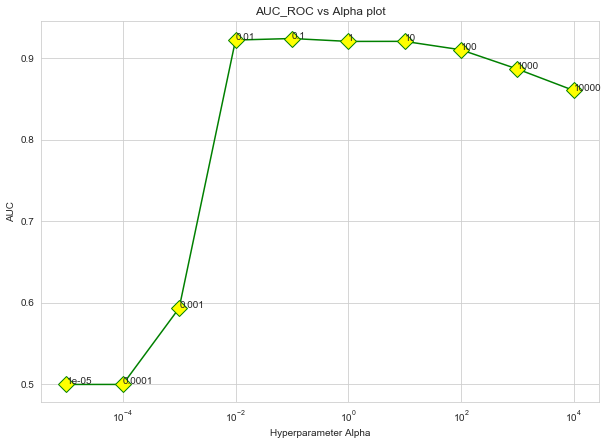

In [92]:
# plot of alpha vs auc_roc
plt.figure(figsize = (10,7))

sns.set_style("whitegrid");

plt.plot(alpha_list, cv_list, color='green',  marker='D',markerfacecolor='yellow', markersize=12)
ind=0
for val in alpha_list:
    plt.annotate('%s' % val,xy=(val,cv_list[ind]),xycoords='data')
    ind=ind+1
plt.xscale('log')
plt.title("AUC_ROC vs Alpha plot")
plt.xlabel('Hyperparameter Alpha')
plt.ylabel('AUC')
plt.show()

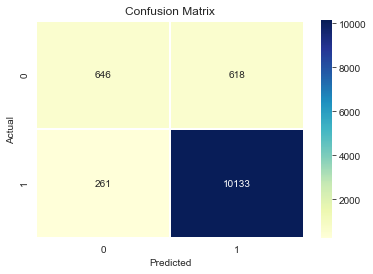

In [93]:
# print(metrics.confusion_matrix(y_test, predicted))

import seaborn as sb
from sklearn.metrics import confusion_matrix
log_optimal = LogisticRegression(penalty='l1',C=opt_alpha) 
log_optimal.fit(X_train, y_train)

conf_matrix = confusion_matrix(y_test,log_optimal.predict(X_test))
df_cmatrix = pd.DataFrame(conf_matrix) #, columns=['Negative', 'Positive'])
sb.heatmap(df_cmatrix, annot=True, fmt='d',cmap="YlGnBu", linewidths=1.4)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## AUC CURVE

In [94]:

# calculating train_auc
from sklearn.metrics import roc_auc_score

cv_list=[]

train_auc_list=[]

alpha_list=[10 ** x for x in range(-5, 5)]
for alp in tqdm(alpha_list):
    clf = LogisticRegression(penalty='l1',C=alp)
    clf.fit(X_train,y_train)
    probs = clf.predict_proba(X_train)
    probs = probs[:,1]
    train_auc = roc_auc_score(y_train, probs)
    train_auc_list.append(train_auc)

100%|██████████| 10/10 [00:04<00:00,  1.97it/s]


In [95]:

# calculating test_auc
from sklearn.metrics import roc_auc_score


cv_list=[]

test_auc_list=[]

alpha_list=[10 ** x for x in range(-5, 5)]
for alp in tqdm(alpha_list):
    clf = LogisticRegression(penalty='l1',C=alp)
    clf.fit(X_train,y_train)
    probs = clf.predict_proba(X_test)
    probs = probs[:,1]
    test_auc = roc_auc_score(y_test, probs)
    test_auc_list.append(test_auc)


100%|██████████| 10/10 [00:04<00:00,  1.87it/s]


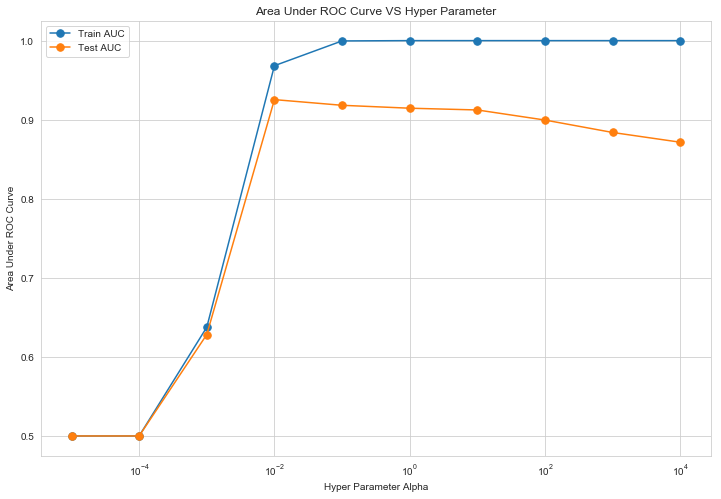

In [96]:

plt.figure(figsize = (12,8))
plt.plot(alpha_list, train_auc_list, marker='.',label="Train AUC",markersize=15)
plt.plot(alpha_list, test_auc_list, marker='.',label="Test AUC",markersize=15)

plt.xscale('log')

plt.legend()
plt.xlabel("Hyper Parameter Alpha")
plt.ylabel("Area Under ROC Curve")
plt.title("Area Under ROC Curve VS Hyper Parameter")
plt.show()

In [97]:
lr_optimal=LogisticRegression(penalty='l1',C=opt_alpha)
lr_optimal.fit(X_train,y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Train AUC: 0.999629
Test AUC: 0.918357


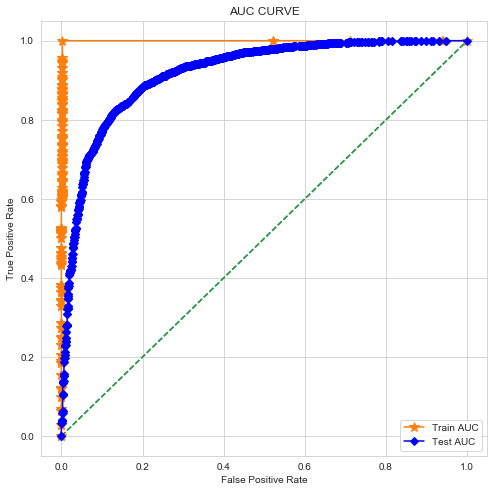

In [98]:

from matplotlib import pyplot
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

plt.figure(figsize = (8,8))
# predict probabilities
probs = lr_optimal.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
train_auc = roc_auc_score(y_train, probs)
print('Train AUC: %f' % train_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_train, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='*',label="Train AUC",markersize=10)


# predict probabilities
probs = lr_optimal.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
test_auc = roc_auc_score(y_test, probs)
print('Test AUC: %f' % test_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='D',color='blue',label="Test AUC",markersize=5)

plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC CURVE")

# show the plot
pyplot.show()




## Conclusion

In [99]:

tfidf_brute_par1=opt_alpha
tfidf_brute_auc1=np.round(test_auc,4)
print("Vectorizer: TFIDF \t Model: Logistic Regression")
print("Best Hyper parameter: ",tfidf_brute_par1)
print("AUC: ",tfidf_brute_auc1)


Vectorizer: TFIDF 	 Model: Logistic Regression
Best Hyper parameter:  0.1
AUC:  0.9184


In [100]:
words=tf_idf_vect.get_feature_names()
coef=clf.coef_.tolist()[0]
coef=np.array(coef).T.tolist()
df_coef=pd.DataFrame({'words':words,'coef':coef})
df_coef1=df_coef.sort_values(['coef', 'words'], ascending=[0, 1])

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [101]:
print('Top 10 feature from Positive class')
print(df_coef1.head(10).to_string(index=False))

Top 10 feature from Positive class
        words      coef
         nice  0.606637
         love  0.406979
       stores  0.400251
    excellent  0.382484
         best  0.331674
    wonderful  0.323830
 tastes great  0.315793
      perfect  0.312553
        tasty  0.307341
    recommend  0.301524


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [102]:
print('Top 10 feature from Negative class')        
print(df_coef1.tail(10).to_string(index=False))

Top 10 feature from Negative class
         words      coef
 avoid product -0.256168
         threw -0.259993
     not happy -0.261348
         stale -0.263892
         bland -0.285441
  disappointed -0.293611
           not -0.318320
         awful -0.349631
         worst -0.372538
     not worth -0.390485


### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [103]:
# Please write all the code with proper documentation

In [104]:
#hiding all the warnings
warnings.filterwarnings('ignore')

# Breaking the data into train and test


X = preprocessed_reviews
y = final['Score']
data=pd.DataFrame(preprocessed_reviews,columns=['review'])
data['score']=final['Score']
X_train, X_test= np.split(data, [int(.67 *len(X))])

X_train1=X_train
X_test1=X_test
print('length of X_train:',len(X_train),'length of X_test:',len(X_test))


length of X_train: 23667 length of X_test: 11658


In [105]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=5)
tf_idf_vect.fit(X_train['review'])
X_train_tfidf= tf_idf_vect.transform(X_train['review'])

X_test_tfidf=tf_idf_vect.transform(X_test['review'])

In [106]:
# Shape of train and test data
print("X_train shape: {0} ".format(len(X_train)))
print("X_test shape:  {0} ".format(len(X_test)))

train_per=len(X_train)/len(X)*100
test_per=len(X_test)/len(X)*100
import math
print("\nPercentage of data in Train : {0:.1f} % and Test :{1:.1f} % ".format(train_per,test_per))

X_train shape: 23667 
X_test shape:  11658 

Percentage of data in Train : 67.0 % and Test :33.0 % 


In [107]:
final_counts=X_train_tfidf
final_test=X_test_tfidf

y_train, y_test= np.split(y, [int(.67 *len(y))])
print("y_train shape: {0} ".format(len(y_train)))
print("y_test shape:  {0} ".format(len(y_test)))

y_train shape: 23667 
y_test shape:  11658 


In [108]:
from sklearn.preprocessing import StandardScaler
stdslr=StandardScaler(with_mean=False)
final_cnt=stdslr.fit_transform(final_counts)
final_tst=stdslr.fit_transform(final_test)

In [109]:
X_train=final_cnt
X_test=final_tst

y_train, y_test= np.split(y, [int(.67 *len(y))])
y_train1=y_train
y_test1=y_test
print("y_train shape: {0} ".format(len(y_train)))
print("y_test shape:  {0} ".format(len(y_test)))

y_train shape: 23667 
y_test shape:  11658 


## k-fold Cross Validation

In [110]:
# applying logistic regression 
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
cv_list=[]
# alpha_list=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
alpha_list=[10 ** x for x in range(-5, 5)]
for alp in tqdm(alpha_list):
    clf = LogisticRegression(penalty='l2',C=alp)
    scores=cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc') # 5 fold cross validation
    cv_list.append(scores.mean())

100%|██████████| 10/10 [00:34<00:00,  4.13s/it]


In [111]:
# optimal alpha
print(cv_list)
opt_alpha=cv_list.index(max(cv_list))
opt_alpha=math.pow(10,opt_alpha)*math.pow(10,-5)
print("Maximum auc is: ",max(cv_list),"for alpha=",opt_alpha)

[0.7781531508077499, 0.9032002813902789, 0.9128824833535096, 0.9093779259059425, 0.9075691365804273, 0.9057517038969658, 0.9007977438496173, 0.8954218991578525, 0.8935309606044735, 0.8932799033203457]
Maximum auc is:  0.9128824833535096 for alpha= 0.001


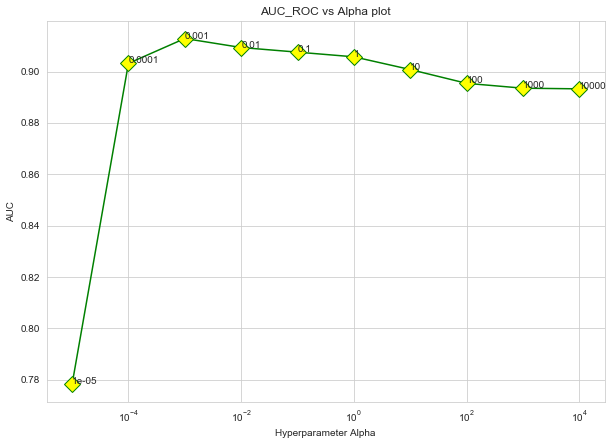

In [112]:
# plot of alpha vs auc_roc
plt.figure(figsize = (10,7))

sns.set_style("whitegrid");

plt.plot(alpha_list, cv_list, color='green',  marker='D',markerfacecolor='yellow', markersize=12)
ind=0
for val in alpha_list:
    plt.annotate('%s' % val,xy=(val,cv_list[ind]),xycoords='data')
    ind=ind+1
plt.xscale('log')
plt.title("AUC_ROC vs Alpha plot")
plt.xlabel('Hyperparameter Alpha')
plt.ylabel('AUC')
plt.show()

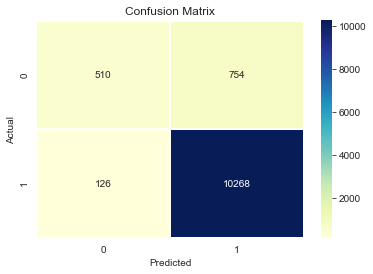

In [113]:
# print(metrics.confusion_matrix(y_test, predicted))

import seaborn as sb
from sklearn.metrics import confusion_matrix
log_optimal = LogisticRegression(penalty='l2',C=opt_alpha) 
log_optimal.fit(X_train, y_train)

conf_matrix = confusion_matrix(y_test,log_optimal.predict(X_test))
df_cmatrix = pd.DataFrame(conf_matrix) #, columns=['Negative', 'Positive'])
sb.heatmap(df_cmatrix, annot=True, fmt='d',cmap="YlGnBu", linewidths=1.4)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## AUC CURVE

In [114]:

# calculating train_auc
from sklearn.metrics import roc_auc_score

cv_list=[]

train_auc_list=[]

alpha_list=[10 ** x for x in range(-5, 5)]
for alp in tqdm(alpha_list):
    clf = LogisticRegression(penalty='l2',C=alp)
    clf.fit(X_train,y_train)
    probs = clf.predict_proba(X_train)
    probs = probs[:,1]
    train_auc = roc_auc_score(y_train, probs)
    train_auc_list.append(train_auc)

100%|██████████| 10/10 [00:10<00:00,  1.15s/it]


In [115]:

# calculating test_auc
from sklearn.metrics import roc_auc_score


cv_list=[]

test_auc_list=[]

alpha_list=[10 ** x for x in range(-5, 5)]
for alp in tqdm(alpha_list):
    clf = LogisticRegression(penalty='l2',C=alp)
    clf.fit(X_train,y_train)
    probs = clf.predict_proba(X_test)
    probs = probs[:,1]
    test_auc = roc_auc_score(y_test, probs)
    test_auc_list.append(test_auc)


100%|██████████| 10/10 [00:08<00:00,  1.00s/it]


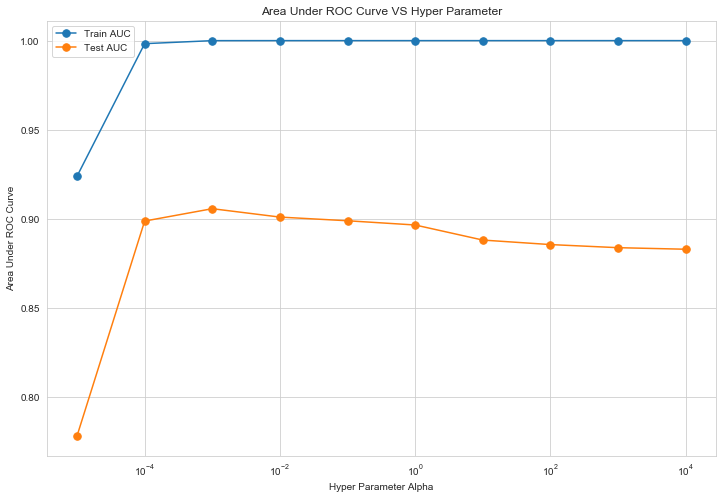

In [116]:

plt.figure(figsize = (12,8))
plt.plot(alpha_list, train_auc_list, marker='.',label="Train AUC",markersize=15)
plt.plot(alpha_list, test_auc_list, marker='.',label="Test AUC",markersize=15)

plt.xscale('log')

plt.legend()
plt.xlabel("Hyper Parameter Alpha")
plt.ylabel("Area Under ROC Curve")
plt.title("Area Under ROC Curve VS Hyper Parameter")
plt.show()

In [117]:
lr_optimal=LogisticRegression(penalty='l2',C=opt_alpha)
lr_optimal.fit(X_train,y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Train AUC: 0.999981
Test AUC: 0.905803


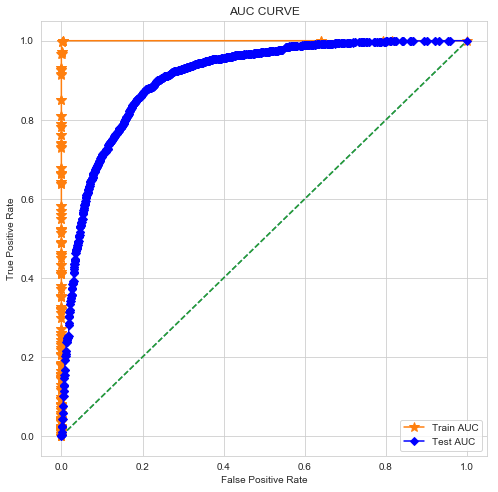

In [118]:

from matplotlib import pyplot
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

plt.figure(figsize = (8,8))
# predict probabilities
probs = lr_optimal.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
train_auc = roc_auc_score(y_train, probs)
print('Train AUC: %f' % train_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_train, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='*',label="Train AUC",markersize=10)


# predict probabilities
probs = lr_optimal.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
test_auc = roc_auc_score(y_test, probs)
print('Test AUC: %f' % test_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='D',color='blue',label="Test AUC",markersize=5)

plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC CURVE")

# show the plot
pyplot.show()




## Conclusion

In [119]:

tfidf_brute_par2=opt_alpha
tfidf_brute_auc2=np.round(test_auc,4)
print("Vectorizer: TFIDF \t Model: Logistic Regression")
print("Best Hyper parameter: ",tfidf_brute_par2)
print("AUC: ",tfidf_brute_auc2)


Vectorizer: TFIDF 	 Model: Logistic Regression
Best Hyper parameter:  0.001
AUC:  0.9058


In [120]:
words=tf_idf_vect.get_feature_names()
coef=clf.coef_.tolist()[0]
coef=np.array(coef).T.tolist()
df_coef=pd.DataFrame({'words':words,'coef':coef})

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [121]:
df_coef1=df_coef.sort_values(['coef', 'words'], ascending=[0, 1])

print('Top 10 feature from Positive class')
print(df_coef1.head(10).to_string(index=False))

Top 10 feature from Positive class
     words      coef
     great  0.625182
      best  0.482563
      love  0.469679
      good  0.454077
 excellent  0.338621
 wonderful  0.311589
     tasty  0.303368
      nice  0.299547
     yummy  0.279143
  favorite  0.267818


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [122]:
print('Top 10 feature from Negative class')        
print(df_coef1.tail(10).to_string(index=False))

Top 10 feature from Negative class
        words      coef
        threw -0.257469
        stale -0.264336
     probably -0.281436
     supposed -0.285162
        sorry -0.285723
        awful -0.302670
 disappointed -0.346554
        bland -0.371140
    not worth -0.393185
        worst -0.405529


## [5.3] <font color='orange'>Logistic Regression on AVG W2V</font>,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [123]:
# Please write all the code with proper documentation

In [124]:
#hiding all the warnings
warnings.filterwarnings('ignore')

# Breaking the data into train and test
from sklearn.model_selection import train_test_split

X = preprocessed_reviews
y = final['Score']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_test= np.split(X, [int(.7 *len(X))])

print('shape of X_train:',len(X_train),'shape of X_test:',len(X_test))

y_train, y_test= np.split(y, [int(.7 *len(y))])
y_train1=y_train
y_test1=y_test

shape of X_train: 24727 shape of X_test: 10598


In [125]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in X_train:
    list_of_sentance.append(sentance.split())

In [126]:


is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.829048752784729), ('excellent', 0.826907217502594), ('wonderful', 0.8114690780639648), ('good', 0.806084156036377), ('fantastic', 0.7833338379859924), ('terrific', 0.7815142273902893), ('fabulous', 0.7535350322723389), ('amazing', 0.7354221343994141), ('perfect', 0.7134096026420593), ('delicious', 0.6838632822036743)]
[('nicest', 0.8412410020828247), ('greatest', 0.837705671787262), ('disgusting', 0.8361834287643433), ('closest', 0.7967396974563599), ('best', 0.7948741912841797), ('tastiest', 0.7925078272819519), ('eaten', 0.7916663885116577), ('omnivore', 0.7721673250198364), ('humble', 0.7698795199394226), ('coolest', 0.7684228420257568)]


In [127]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])
print(len(w2v_words))
# length=len(w2v_words)

number of words that occured minimum 5 times  9710
sample words  ['witty', 'little', 'book', 'makes', 'son', 'laugh', 'loud', 'car', 'driving', 'along', 'always', 'sing', 'learned', 'india', 'roses', 'love', 'new', 'words', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'remember', 'seeing', 'show', 'television', 'years', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirty', 'something', 'used', 'series', 'books', 'songs', 'student', 'teaching', 'turned', 'whole', 'school', 'purchasing', 'cd', 'children']
9710


In [128]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))
sent_vectors=np.array(sent_vectors)

100%|██████████| 24727/24727 [01:06<00:00, 371.90it/s]

24727
50


In [129]:
sent_vec_test=[]
sentance_test=[]
for sentance in X_test:
    sentance_test.append(sentance.split())
    

for sent in tqdm(sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vec_test.append(sent_vec)
print(len(sent_vec_test))
print(len(sent_vec_test[0]))
sent_vec_test=np.array(sent_vec_test)

100%|██████████| 10598/10598 [00:27<00:00, 387.63it/s]

10598
50


In [130]:
# Shape of train and test data
print("X_train shape: {0}   y_train shape: {1}".format(len(X_train), len(y_train)))
print("X_test shape:  {0}    y_test shape: {1}".format(len(X_test), len(y_test)))

train_per=len(X_train)/len(X)*100
test_per=len(X_test)/len(X)*100
import math
print("\nPercentage of data in Train : {0:.1f} % and Test :{1:.1f} % ".format(train_per,test_per))

X_train shape: 24727   y_train shape: 24727
X_test shape:  10598    y_test shape: 10598

Percentage of data in Train : 70.0 % and Test :30.0 % 


In [131]:
from sklearn.preprocessing import StandardScaler
stdslr=StandardScaler(with_mean=False)
final_cnt=stdslr.fit_transform(sent_vectors)
final_tst=stdslr.fit_transform(sent_vec_test)

In [132]:
X_train=final_cnt
X_test=final_tst

print("y_train shape: {0} ".format(len(y_train)))
print("y_test shape:  {0} ".format(len(y_test)))

y_train shape: 24727 
y_test shape:  10598 


## k-fold Cross Validation

In [133]:
# applying logistic regression 
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
cv_list=[]

alpha_list=[10 ** x for x in range(-3, 3)]
for alp in tqdm(alpha_list):
    clf = LogisticRegression(penalty='l1',C=alp)  
    scores=cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc') # 5 fold cross validation
    cv_list.append(scores.mean())

100%|██████████| 6/6 [01:35<00:00, 19.65s/it]


In [134]:
# optimal alpha
print(cv_list)
opt_alpha=cv_list.index(max(cv_list))
opt_alpha=math.pow(10,opt_alpha)*math.pow(10,-3)
print("Maximum auc is: ",max(cv_list),"for alpha=",opt_alpha)

[0.7247432509399248, 0.8640802167295497, 0.8767890296185982, 0.8784042234535446, 0.8783666192005228, 0.8783557704324755]
Maximum auc is:  0.8784042234535446 for alpha= 1.0


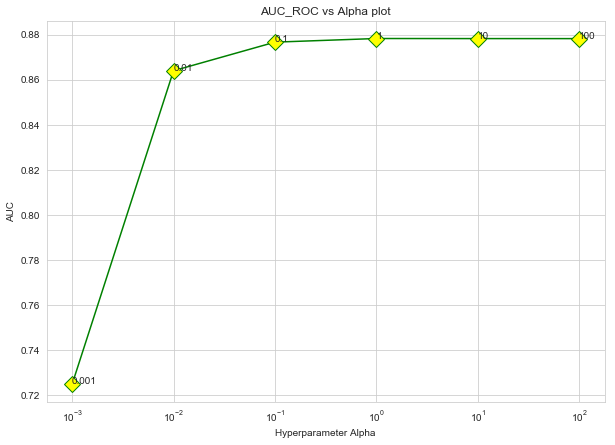

In [135]:
# plot of alpha vs auc_roc
plt.figure(figsize = (10,7))

sns.set_style("whitegrid");

plt.plot(alpha_list, cv_list, color='green',  marker='D',markerfacecolor='yellow', markersize=12)
ind=0
for val in alpha_list:
    plt.annotate('%s' % val,xy=(val,cv_list[ind]),xycoords='data')
    ind=ind+1
plt.xscale('log')
plt.title("AUC_ROC vs Alpha plot")
plt.xlabel('Hyperparameter Alpha')
plt.ylabel('AUC')
plt.show()

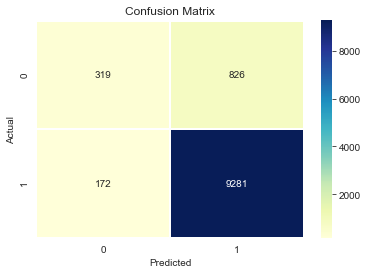

In [136]:
# print(metrics.confusion_matrix(y_test, predicted))

import seaborn as sb
from sklearn.metrics import confusion_matrix
log_optimal = LogisticRegression(penalty='l1',C=opt_alpha) 
log_optimal.fit(X_train, y_train)

conf_matrix = confusion_matrix(y_test,log_optimal.predict(X_test))
df_cmatrix = pd.DataFrame(conf_matrix) #, columns=['Negative', 'Positive'])
sb.heatmap(df_cmatrix, annot=True, fmt='d',cmap="YlGnBu", linewidths=1.4)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## AUC CURVE

In [137]:

# calculating train_auc
from sklearn.metrics import roc_auc_score

cv_list=[]

train_auc_list=[]

alpha_list=[10 ** x for x in range(-3, 3)]
for alp in tqdm(alpha_list):
    clf = LogisticRegression(penalty='l1',C=alp)
    clf.fit(X_train,y_train)
    probs = clf.predict_proba(X_train)
    probs = probs[:,1]
    train_auc = roc_auc_score(y_train, probs)
    train_auc_list.append(train_auc)

100%|██████████| 6/6 [00:22<00:00,  4.47s/it]


In [138]:

# calculating train_auc
from sklearn.metrics import roc_auc_score

cv_list=[]

train_auc_list=[]

alpha_list=[10 ** x for x in range(-3, 3)]
for alp in tqdm(alpha_list):
    clf = LogisticRegression(penalty='l1',C=alp)
    clf.fit(X_train,y_train)
    probs = clf.predict_proba(X_train)
    probs = probs[:,1]
    train_auc = roc_auc_score(y_train, probs)
    train_auc_list.append(train_auc)

100%|██████████| 6/6 [00:21<00:00,  4.41s/it]


In [139]:

# calculating test_auc
from sklearn.metrics import roc_auc_score


cv_list=[]

test_auc_list=[]

alpha_list=[10 ** x for x in range(-3, 3)]
for alp in tqdm(alpha_list):
    clf = LogisticRegression(penalty='l1',C=alp)
    clf.fit(X_train,y_train)
    probs = clf.predict_proba(X_test)
    probs = probs[:,1]
    test_auc = roc_auc_score(y_test, probs)
    test_auc_list.append(test_auc)


100%|██████████| 6/6 [00:21<00:00,  4.43s/it]


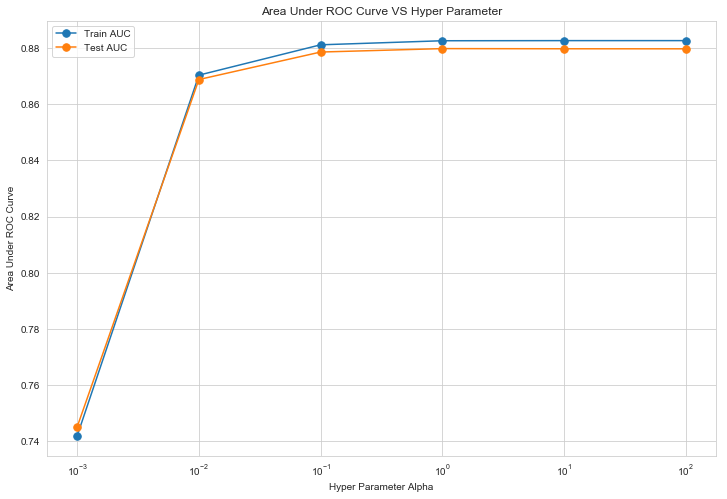

In [140]:

plt.figure(figsize = (12,8))
plt.plot(alpha_list, train_auc_list, marker='.',label="Train AUC",markersize=15)
plt.plot(alpha_list, test_auc_list, marker='.',label="Test AUC",markersize=15)

plt.xscale('log')

plt.legend()
plt.xlabel("Hyper Parameter Alpha")
plt.ylabel("Area Under ROC Curve")
plt.title("Area Under ROC Curve VS Hyper Parameter")
plt.show()

In [141]:
lr_optimal=LogisticRegression(penalty='l1',C=opt_alpha)
lr_optimal.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Train AUC: 0.882566
Test AUC: 0.879774


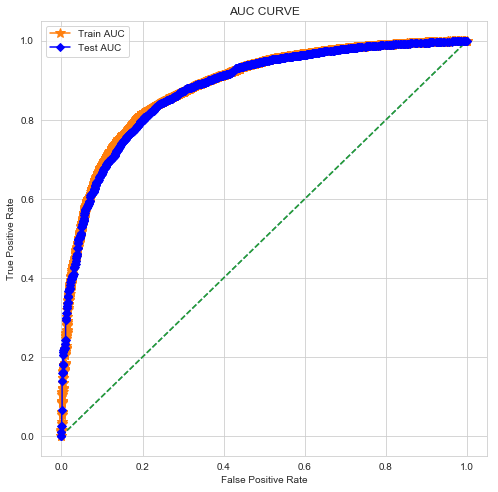

In [142]:

from matplotlib import pyplot
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

plt.figure(figsize = (8,8))
# predict probabilities
probs = lr_optimal.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
train_auc = roc_auc_score(y_train, probs)
print('Train AUC: %f' % train_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_train, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='*',label="Train AUC",markersize=10)


# predict probabilities
probs = lr_optimal.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
test_auc = roc_auc_score(y_test, probs)
print('Test AUC: %f' % test_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='D',color='blue',label="Test AUC",markersize=5)

plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC CURVE")

# show the plot
pyplot.show()




## Conclusion

In [143]:

avgwv_brute_par1=opt_alpha
avgwv_brute_auc1=np.round(test_auc,4)
print("Vectorizer: AVG W2V \t Model: Logistic Regression")
print("Best Hyper parameter: ",avgwv_brute_par1)
print("AUC: ",avgwv_brute_auc1)


Vectorizer: AVG W2V 	 Model: Logistic Regression
Best Hyper parameter:  1.0
AUC:  0.8798


### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [149]:
# Please write all the code with proper documentation

In [150]:
#hiding all the warnings
warnings.filterwarnings('ignore')

# Breaking the data into train and test
from sklearn.model_selection import train_test_split

X = preprocessed_reviews
y = final['Score']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_test= np.split(X, [int(.7 *len(X))])

print('shape of X_train:',len(X_train),'shape of X_test:',len(X_test))

y_train, y_test= np.split(y, [int(.7 *len(y))])
y_train1=y_train
y_test1=y_test

shape of X_train: 24727 shape of X_test: 10598


In [151]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in X_train:
    list_of_sentance.append(sentance.split())

In [152]:


is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8111438155174255), ('good', 0.8013650178909302), ('excellent', 0.8003182411193848), ('wonderful', 0.799699068069458), ('fantastic', 0.7857326865196228), ('terrific', 0.7734400629997253), ('amazing', 0.7389565110206604), ('perfect', 0.7089570760726929), ('fabulous', 0.6894646286964417), ('delicious', 0.6866232752799988)]
[('nicest', 0.8506761193275452), ('greatest', 0.8476921319961548), ('eaten', 0.8076852560043335), ('richest', 0.7940590381622314), ('disgusting', 0.7913949489593506), ('best', 0.7891520261764526), ('coolest', 0.7838975191116333), ('closest', 0.7831836342811584), ('snapper', 0.7796773314476013), ('sweetest', 0.7747287750244141)]


In [153]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])
print(len(w2v_words))
# length=len(w2v_words)

number of words that occured minimum 5 times  9710
sample words  ['witty', 'little', 'book', 'makes', 'son', 'laugh', 'loud', 'car', 'driving', 'along', 'always', 'sing', 'learned', 'india', 'roses', 'love', 'new', 'words', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'remember', 'seeing', 'show', 'television', 'years', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirty', 'something', 'used', 'series', 'books', 'songs', 'student', 'teaching', 'turned', 'whole', 'school', 'purchasing', 'cd', 'children']
9710


In [154]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))
sent_vectors=np.array(sent_vectors)

100%|██████████| 24727/24727 [01:22<00:00, 300.83it/s]

24727
50


In [155]:
sent_vec_test=[]
sentance_test=[]
for sentance in X_test:
    sentance_test.append(sentance.split())
    

for sent in tqdm(sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vec_test.append(sent_vec)
print(len(sent_vec_test))
print(len(sent_vec_test[0]))
sent_vec_test=np.array(sent_vec_test)

100%|██████████| 10598/10598 [00:25<00:00, 407.86it/s]

10598
50


In [158]:
# Shape of train and test data
print("X_train shape: {0}   y_train shape: {1}".format(len(X_train), len(y_train)))
print("X_test shape:  {0}    y_test shape: {1}".format(len(X_test), len(y_test)))

train_per=len(X_train)/len(X)*100
test_per=len(X_test)/len(X)*100
import math
print("\nPercentage of data in Train : {0:.1f} % and Test :{1:.1f} % ".format(train_per,test_per))

X_train shape: 24727   y_train shape: 24727
X_test shape:  10598    y_test shape: 10598

Percentage of data in Train : 70.0 % and Test :30.0 % 


In [159]:
from sklearn.preprocessing import StandardScaler
stdslr=StandardScaler(with_mean=False)
final_cnt=stdslr.fit_transform(sent_vectors)
final_tst=stdslr.fit_transform(sent_vec_test)

In [160]:
X_train=final_cnt
X_test=final_tst

print("y_train shape: {0} ".format(len(y_train)))
print("y_test shape:  {0} ".format(len(y_test)))

y_train shape: 24727 
y_test shape:  10598 


## k-fold Cross Validation

In [161]:
# applying logistic regression 
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
cv_list=[]
# alpha_list=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
alpha_list=[10 ** x for x in range(-3, 3)]
for alp in tqdm(alpha_list):
    clf = LogisticRegression(penalty='l2',C=alp)
    scores=cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc') # 5 fold cross validation
    cv_list.append(scores.mean())

100%|██████████| 6/6 [00:13<00:00,  2.45s/it]


In [162]:
# optimal alpha
print(cv_list)
opt_alpha=cv_list.index(max(cv_list))
opt_alpha=math.pow(10,opt_alpha)*math.pow(10,-3)
print("Maximum auc is: ",max(cv_list),"for alpha=",opt_alpha)

[0.8618324776951871, 0.8712396506156214, 0.873225245958702, 0.8734476881443447, 0.873411964258122, 0.8734074767875303]
Maximum auc is:  0.8734476881443447 for alpha= 1.0


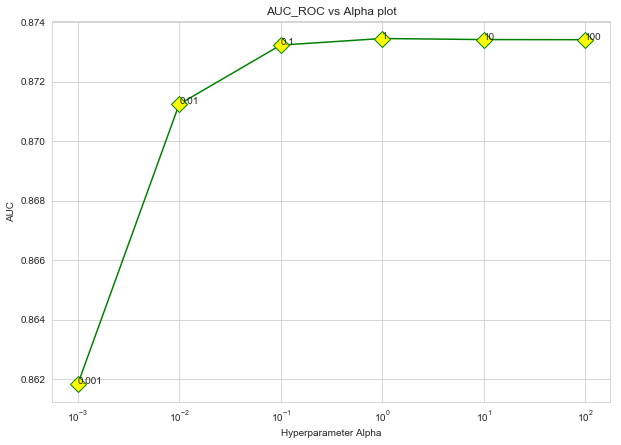

In [163]:
# plot of alpha vs auc_roc
plt.figure(figsize = (10,7))

sns.set_style("whitegrid");

plt.plot(alpha_list, cv_list, color='green',  marker='D',markerfacecolor='yellow', markersize=12)
ind=0
for val in alpha_list:
    plt.annotate('%s' % val,xy=(val,cv_list[ind]),xycoords='data')
    ind=ind+1
plt.xscale('log')
plt.title("AUC_ROC vs Alpha plot")
plt.xlabel('Hyperparameter Alpha')
plt.ylabel('AUC')
plt.show()

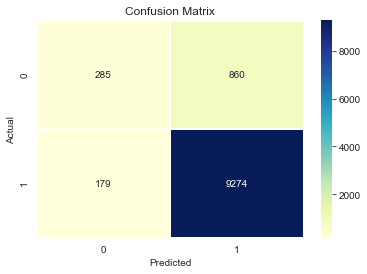

In [164]:
# print(metrics.confusion_matrix(y_test, predicted))

import seaborn as sb
from sklearn.metrics import confusion_matrix
log_optimal = LogisticRegression(penalty='l2',C=opt_alpha) 
log_optimal.fit(X_train, y_train)

conf_matrix = confusion_matrix(y_test,log_optimal.predict(X_test))
df_cmatrix = pd.DataFrame(conf_matrix) #, columns=['Negative', 'Positive'])
sb.heatmap(df_cmatrix, annot=True, fmt='d',cmap="YlGnBu", linewidths=1.4)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## AUC CURVE

In [165]:

# calculating train_auc
from sklearn.metrics import roc_auc_score

cv_list=[]

train_auc_list=[]

alpha_list=[10 ** x for x in range(-3, 3)]
for alp in tqdm(alpha_list):
    clf = LogisticRegression(penalty='l2',C=alp)
    clf.fit(X_train,y_train)
    probs = clf.predict_proba(X_train)
    probs = probs[:,1]
    train_auc = roc_auc_score(y_train, probs)
    train_auc_list.append(train_auc)

100%|██████████| 6/6 [00:03<00:00,  1.33it/s]


In [166]:

# calculating test_auc
from sklearn.metrics import roc_auc_score


cv_list=[]

test_auc_list=[]

alpha_list=[10 ** x for x in range(-3, 3)]
for alp in tqdm(alpha_list):
    clf = LogisticRegression(penalty='l2',C=alp)
    clf.fit(X_train,y_train)
    probs = clf.predict_proba(X_test)
    probs = probs[:,1]
    test_auc = roc_auc_score(y_test, probs)
    test_auc_list.append(test_auc)


100%|██████████| 6/6 [00:03<00:00,  1.56it/s]


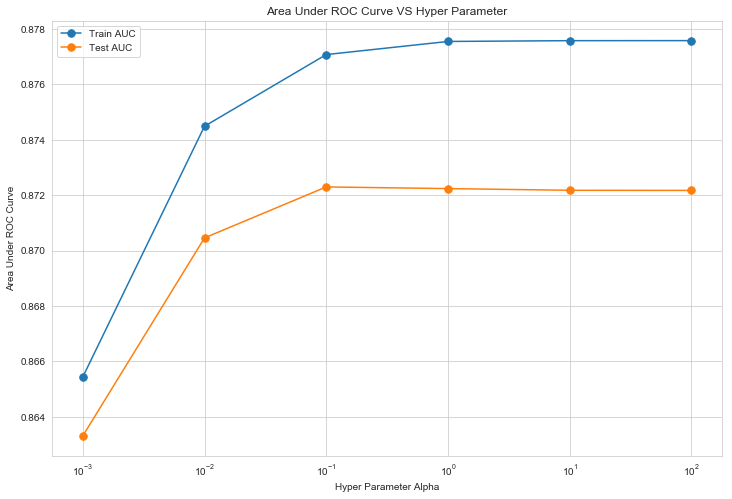

In [167]:

plt.figure(figsize = (12,8))
plt.plot(alpha_list, train_auc_list, marker='.',label="Train AUC",markersize=15)
plt.plot(alpha_list, test_auc_list, marker='.',label="Test AUC",markersize=15)

plt.xscale('log')

plt.legend()
plt.xlabel("Hyper Parameter Alpha")
plt.ylabel("Area Under ROC Curve")
plt.title("Area Under ROC Curve VS Hyper Parameter")
plt.show()

In [168]:
lr_optimal=LogisticRegression(penalty='l2',C=opt_alpha)
lr_optimal.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Train AUC: 0.877544
Test AUC: 0.872235


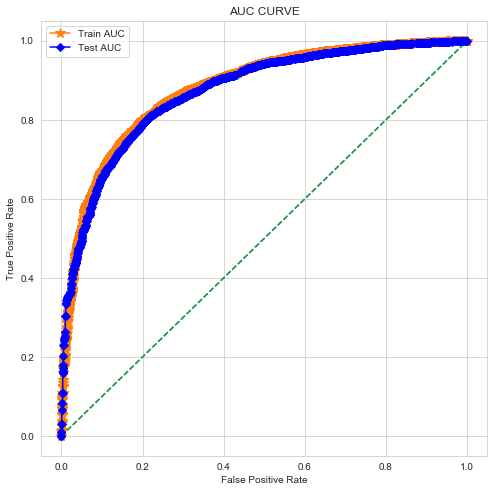

In [169]:

from matplotlib import pyplot
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

plt.figure(figsize = (8,8))
# predict probabilities
probs = lr_optimal.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
train_auc = roc_auc_score(y_train, probs)
print('Train AUC: %f' % train_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_train, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='*',label="Train AUC",markersize=10)


# predict probabilities
probs = lr_optimal.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
test_auc = roc_auc_score(y_test, probs)
print('Test AUC: %f' % test_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='D',color='blue',label="Test AUC",markersize=5)

plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC CURVE")

# show the plot
pyplot.show()




## Conclusion

In [170]:

avgwv_brute_par2=opt_alpha
avgwv_brute_auc2=np.round(test_auc,4)
print("Vectorizer: AVG W2V \t Model: Logistic Regression")
print("Best Hyper parameter: ",avgwv_brute_par2)
print("AUC: ",avgwv_brute_auc2)


Vectorizer: AVG W2V 	 Model: Logistic Regression
Best Hyper parameter:  1.0
AUC:  0.8722


## [5.4] <font color='orange'>Logistic Regression on TFIDF W2V</font>,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [171]:
# Please write all the code with proper documentation

In [172]:
#hiding all the warnings
warnings.filterwarnings('ignore')

# Breaking the data into train and test
# from sklearn.model_selection import train_test_split

X = preprocessed_reviews
y = final['Score']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train, X_test= np.split(X, [int(.7 *len(X))])

print('shape of X_train:',len(X_train),'shape of X_test:',len(X_test))

y_train, y_test= np.split(y, [int(.7 *len(y))])
y_train1=y_train
y_test1=y_test


shape of X_train: 24727 shape of X_test: 10598


In [173]:
# Shape of train and test data
print("X_train shape: {0}   y_train shape: {1}".format(len(X_train), len(y_train)))
print("X_test shape:  {0}    y_test shape: {1}".format(len(X_test), len(y_test)))

train_per=len(X_train)/len(X)*100
test_per=len(X_test)/len(X)*100
import math
print("\nPercentage of data in Train : {0:.1f} % and Test :{1:.1f} % ".format(train_per,test_per))

X_train shape: 24727   y_train shape: 24727
X_test shape:  10598    y_test shape: 10598

Percentage of data in Train : 70.0 % and Test :30.0 % 


In [174]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
# TF-IDF weighted Word2Vec
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████| 24727/24727 [14:53<00:00, 27.66it/s] 


In [175]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 10598/10598 [07:12<00:00, 23.46it/s] 


In [176]:
# X_train=tfidf_sent_vectors
# X_test=tfidf_sent_vectors_test

X_train=tfidf_sent_vectors_train
X_test=tfidf_sent_vectors_test

## k-fold Cross Validation

In [177]:
# applying logistic regression 
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
cv_list=[]

alpha_list=[10 ** x for x in range(-3, 3)]
for alp in tqdm(alpha_list):
    clf = LogisticRegression(penalty='l1',C=alp)
    scores=cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc') # 5 fold cross validation
    cv_list.append(scores.mean())

100%|██████████| 6/6 [01:14<00:00, 16.65s/it]


In [178]:
# optimal alpha
print(cv_list)
opt_alpha=cv_list.index(max(cv_list))
opt_alpha=math.pow(10,opt_alpha)*math.pow(10,-3)
print("Maximum auc is: ",max(cv_list),"for alpha=",opt_alpha)

[0.6321222656910189, 0.8087762043641071, 0.8410520644334853, 0.8453905818740957, 0.8456116971237592, 0.8455787164268529]
Maximum auc is:  0.8456116971237592 for alpha= 10.0


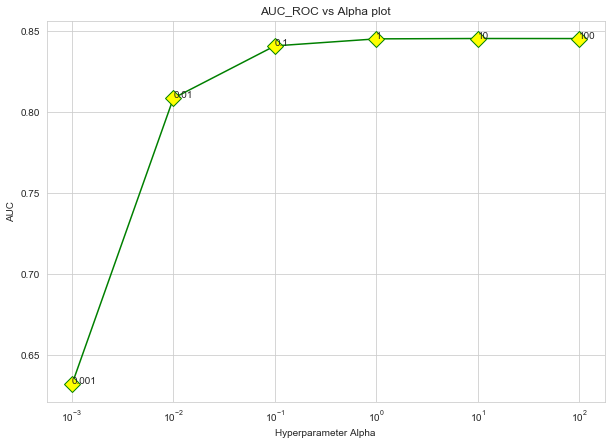

In [179]:
# plot of alpha vs auc_roc
plt.figure(figsize = (10,7))

sns.set_style("whitegrid");

plt.plot(alpha_list, cv_list, color='green',  marker='D',markerfacecolor='yellow', markersize=12)
ind=0
for val in alpha_list:
    plt.annotate('%s' % val,xy=(val,cv_list[ind]),xycoords='data')
    ind=ind+1
plt.xscale('log')
plt.title("AUC_ROC vs Alpha plot")
plt.xlabel('Hyperparameter Alpha')
plt.ylabel('AUC')
plt.show()

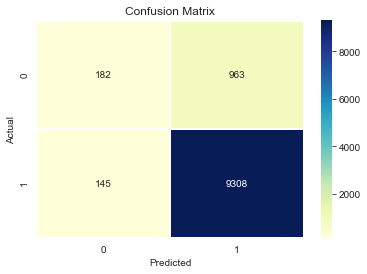

In [180]:
# print(metrics.confusion_matrix(y_test, predicted))

import seaborn as sb
from sklearn.metrics import confusion_matrix
log_optimal = LogisticRegression(penalty='l1',C=opt_alpha) 
log_optimal.fit(X_train, y_train)

conf_matrix = confusion_matrix(y_test,log_optimal.predict(X_test))
df_cmatrix = pd.DataFrame(conf_matrix) #, columns=['Negative', 'Positive'])
sb.heatmap(df_cmatrix, annot=True, fmt='d',cmap="YlGnBu", linewidths=1.4)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## AUC CURVE

In [181]:

# calculating train_auc
from sklearn.metrics import roc_auc_score

cv_list=[]

train_auc_list=[]

alpha_list=[10 ** x for x in range(-3, 3)]
for alp in tqdm(alpha_list):
    clf = LogisticRegression(penalty='l1',C=alp)
    clf.fit(X_train,y_train)
    probs = clf.predict_proba(X_train)
    probs = probs[:,1]
    train_auc = roc_auc_score(y_train, probs)
    train_auc_list.append(train_auc)

100%|██████████| 6/6 [00:22<00:00,  5.08s/it]


In [182]:

# calculating test_auc
from sklearn.metrics import roc_auc_score


cv_list=[]

test_auc_list=[]

alpha_list=[10 ** x for x in range(-3, 3)]
for alp in tqdm(alpha_list):
    clf = LogisticRegression(penalty='l1',C=alp)
    clf.fit(X_train,y_train)
    probs = clf.predict_proba(X_test)
    probs = probs[:,1]
    test_auc = roc_auc_score(y_test, probs)
    test_auc_list.append(test_auc)


100%|██████████| 6/6 [00:20<00:00,  4.55s/it]


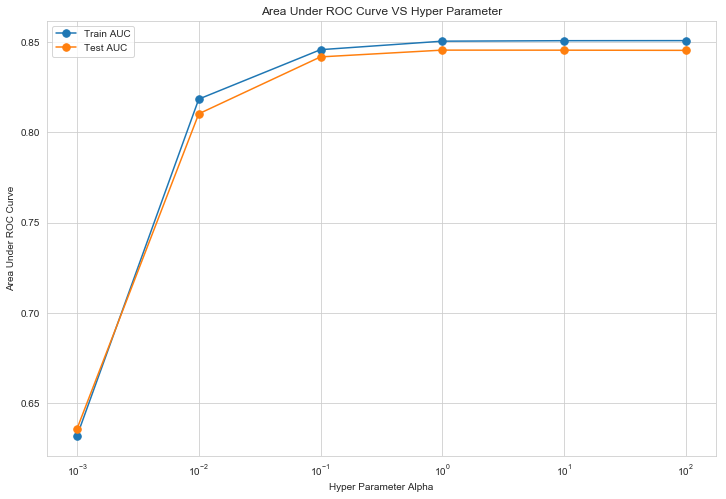

In [183]:

plt.figure(figsize = (12,8))
plt.plot(alpha_list, train_auc_list, marker='.',label="Train AUC",markersize=15)
plt.plot(alpha_list, test_auc_list, marker='.',label="Test AUC",markersize=15)

plt.xscale('log')

plt.legend()
plt.xlabel("Hyper Parameter Alpha")
plt.ylabel("Area Under ROC Curve")
plt.title("Area Under ROC Curve VS Hyper Parameter")
plt.show()

In [184]:
lr_optimal=LogisticRegression(penalty='l1',C=opt_alpha)
lr_optimal.fit(X_train,y_train)

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Train AUC: 0.850783
Test AUC: 0.845526


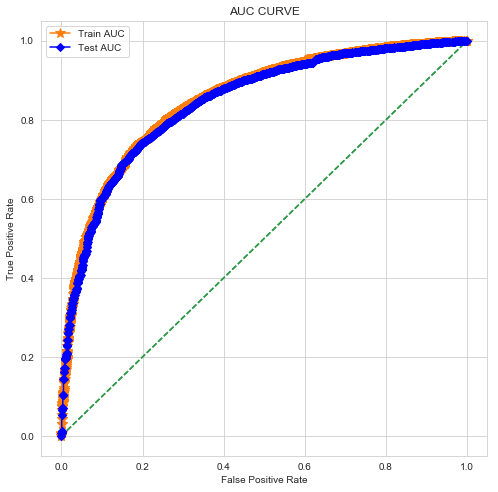

In [185]:

from matplotlib import pyplot
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

plt.figure(figsize = (8,8))
# predict probabilities
probs = lr_optimal.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
train_auc = roc_auc_score(y_train, probs)
print('Train AUC: %f' % train_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_train, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='*',label="Train AUC",markersize=10)


# predict probabilities
probs = lr_optimal.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
test_auc = roc_auc_score(y_test, probs)
print('Test AUC: %f' % test_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='D',color='blue',label="Test AUC",markersize=5)

plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC CURVE")

# show the plot
pyplot.show()




## Conclusion

In [186]:

tfidfwv_brute_par1=opt_alpha
tfidfwv_brute_auc1=np.round(test_auc,4)
print("Vectorizer: TFIDF W2V \t Model: Logistic Regression")
print("Best Hyper parameter: ",tfidfwv_brute_par1)
print("AUC: ",tfidfwv_brute_auc1)


Vectorizer: TFIDF W2V 	 Model: Logistic Regression
Best Hyper parameter:  10.0
AUC:  0.8455


### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [187]:
# Please write all the code with proper documentation

In [199]:
#hiding all the warnings
warnings.filterwarnings('ignore')

# Breaking the data into train and test
# from sklearn.model_selection import train_test_split

X = preprocessed_reviews
y = final['Score']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train, X_test= np.split(X, [int(.7 *len(X))])

print('shape of X_train:',len(X_train),'shape of X_test:',len(X_test))

y_train, y_test= np.split(y, [int(.7 *len(y))])
y_train1=y_train
y_test1=y_test


shape of X_train: 24727 shape of X_test: 10598


In [200]:
# Shape of train and test data
print("X_train shape: {0}   y_train shape: {1}".format(len(X_train), len(y_train)))
print("X_test shape:  {0}    y_test shape: {1}".format(len(X_test), len(y_test)))

train_per=len(X_train)/len(X)*100
test_per=len(X_test)/len(X)*100
import math
print("\nPercentage of data in Train : {0:.1f} % and Test :{1:.1f} % ".format(train_per,test_per))

X_train shape: 24727   y_train shape: 24727
X_test shape:  10598    y_test shape: 10598

Percentage of data in Train : 70.0 % and Test :30.0 % 


In [203]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
# TF-IDF weighted Word2Vec
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentance_train: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

In [205]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentance_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

In [206]:
# X_train=tfidf_sent_vectors
# X_test=tfidf_sent_vectors_test

X_train=tfidf_sent_vectors_train
X_test=tfidf_sent_vectors_test

## k-fold Cross Validation

In [208]:
# applying logistic regression 
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
cv_list=[]

alpha_list=[10 ** x for x in range(-3, 3)]
for alp in alpha_list:
    clf = LogisticRegression(penalty='l1',C=alp)
    scores=cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc') # 5 fold cross validation
    cv_list.append(scores.mean())

In [209]:
# optimal alpha
print(cv_list)
opt_alpha=cv_list.index(max(cv_list))
opt_alpha=math.pow(10,opt_alpha)*math.pow(10,-3)
print("Maximum auc is: ",max(cv_list),"for alpha=",opt_alpha)

[0.6321222656910189, 0.8087702347107886, 0.8410608175330208, 0.845380241295642, 0.8456098582166494, 0.8455840517879194]
Maximum auc is:  0.8456098582166494 for alpha= 10.0


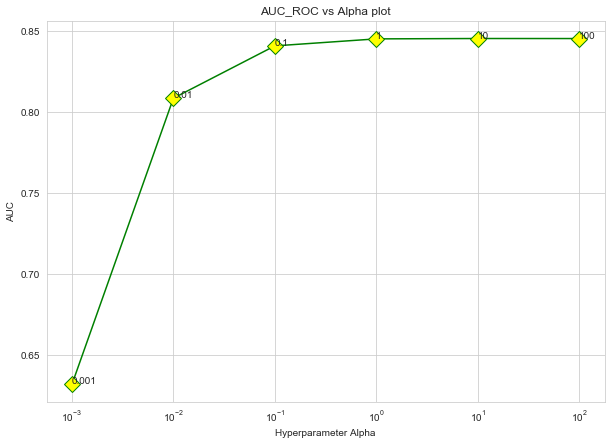

In [210]:
# plot of alpha vs auc_roc
plt.figure(figsize = (10,7))

sns.set_style("whitegrid");

plt.plot(alpha_list, cv_list, color='green',  marker='D',markerfacecolor='yellow', markersize=12)
ind=0
for val in alpha_list:
    plt.annotate('%s' % val,xy=(val,cv_list[ind]),xycoords='data')
    ind=ind+1
plt.xscale('log')
plt.title("AUC_ROC vs Alpha plot")
plt.xlabel('Hyperparameter Alpha')
plt.ylabel('AUC')
plt.show()

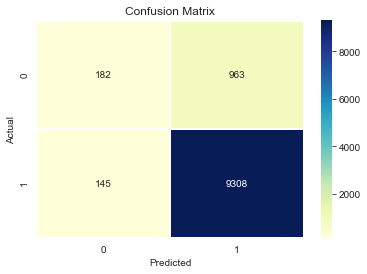

In [211]:
# print(metrics.confusion_matrix(y_test, predicted))

import seaborn as sb
from sklearn.metrics import confusion_matrix
log_optimal = LogisticRegression(penalty='l1',C=opt_alpha) 
log_optimal.fit(X_train, y_train)

conf_matrix = confusion_matrix(y_test,log_optimal.predict(X_test))
df_cmatrix = pd.DataFrame(conf_matrix) #, columns=['Negative', 'Positive'])
sb.heatmap(df_cmatrix, annot=True, fmt='d',cmap="YlGnBu", linewidths=1.4)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## AUC CURVE

In [213]:

# calculating train_auc
from sklearn.metrics import roc_auc_score

cv_list=[]

train_auc_list=[]

alpha_list=[10 ** x for x in range(-3, 3)]
for alp in alpha_list:
    clf = LogisticRegression(penalty='l1',C=alp)
    clf.fit(X_train,y_train)
    probs = clf.predict_proba(X_train)
    probs = probs[:,1]
    train_auc = roc_auc_score(y_train, probs)
    train_auc_list.append(train_auc)

In [214]:

# calculating test_auc
from sklearn.metrics import roc_auc_score


cv_list=[]

test_auc_list=[]

alpha_list=[10 ** x for x in range(-3, 3)]
for alp in alpha_list:
    clf = LogisticRegression(penalty='l1',C=alp)
    clf.fit(X_train,y_train)
    probs = clf.predict_proba(X_test)
    probs = probs[:,1]
    test_auc = roc_auc_score(y_test, probs)
    test_auc_list.append(test_auc)


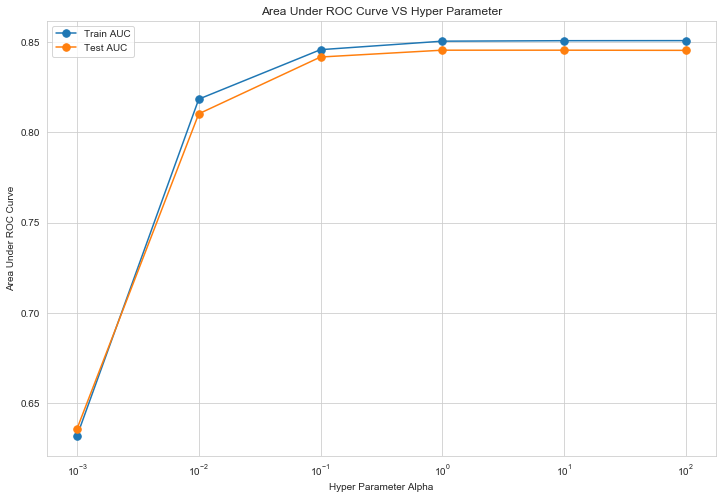

In [215]:

plt.figure(figsize = (12,8))
plt.plot(alpha_list, train_auc_list, marker='.',label="Train AUC",markersize=15)
plt.plot(alpha_list, test_auc_list, marker='.',label="Test AUC",markersize=15)

plt.xscale('log')

plt.legend()
plt.xlabel("Hyper Parameter Alpha")
plt.ylabel("Area Under ROC Curve")
plt.title("Area Under ROC Curve VS Hyper Parameter")
plt.show()

In [216]:
lr_optimal=LogisticRegression(penalty='l1',C=opt_alpha)
lr_optimal.fit(X_train,y_train)

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Train AUC: 0.850784
Test AUC: 0.845526


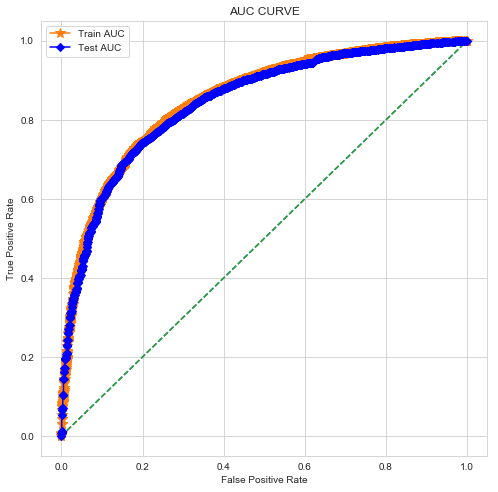

In [217]:

from matplotlib import pyplot
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

plt.figure(figsize = (8,8))
# predict probabilities
probs = lr_optimal.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
train_auc = roc_auc_score(y_train, probs)
print('Train AUC: %f' % train_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_train, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='*',label="Train AUC",markersize=10)


# predict probabilities
probs = lr_optimal.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
test_auc = roc_auc_score(y_test, probs)
print('Test AUC: %f' % test_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='D',color='blue',label="Test AUC",markersize=5)

plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC CURVE")

# show the plot
pyplot.show()




## Conclusion

In [218]:

tfidfwv_brute_par2=opt_alpha
tfidfwv_brute_auc2=np.round(test_auc,4)
print("Vectorizer: TFIDF W2V \t Model: Logistic Regression")
print("Best Hyper parameter: ",tfidfwv_brute_par2)
print("AUC: ",tfidfwv_brute_auc2)


Vectorizer: TFIDF W2V 	 Model: Logistic Regression
Best Hyper parameter:  10.0
AUC:  0.8455


## Feature Engineering

### Combining Summary and Review text

In [220]:
# taking reviws and summary both
from tqdm import tqdm
summary = []
# tqdm is for printing the status bar

for sentance in final['Summary'].values:
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    summary.append(sentance.strip())


In [221]:

comb_reviewtxt=[]

for i in range(len(summary)):
    comb_reviewtxt.append(summary[i]+' '+preprocessed_reviews[i])
  

In [222]:
print(summary[1])
print(preprocessed_reviews[1])
print()
print(comb_reviewtxt[1])

whole series great way spend time child
remember seeing show aired television years ago child sister later bought lp day thirty something used series books songs student teaching preschoolers turned whole school purchasing cd along books children tradition lives

whole series great way spend time child remember seeing show aired television years ago child sister later bought lp day thirty something used series books songs student teaching preschoolers turned whole school purchasing cd along books children tradition lives


In [223]:
#hiding all the warnings
warnings.filterwarnings('ignore')

# Breaking the data into train and test


X = comb_reviewtxt
y = final['Score']
data=pd.DataFrame(comb_reviewtxt,columns=['SummaryText'])
data['score']=final['Score']
X_train, X_test= np.split(data, [int(.67 *len(X))])

X_train1=X_train
X_test1=X_test
print('length of X_train:',len(X_train),'length of X_test:',len(X_test))


length of X_train: 23667 length of X_test: 11658


In [224]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=5)
tf_idf_vect.fit(X_train['SummaryText'])
X_train_tfidf= tf_idf_vect.transform(X_train['SummaryText'])

X_test_tfidf=tf_idf_vect.transform(X_test['SummaryText'])

In [225]:
# Shape of train and test data
print("X_train shape: {0} ".format(len(X_train)))
print("X_test shape:  {0} ".format(len(X_test)))

train_per=len(X_train)/len(X)*100
test_per=len(X_test)/len(X)*100
import math
print("\nPercentage of data in Train : {0:.1f} % and Test :{1:.1f} % ".format(train_per,test_per))

X_train shape: 23667 
X_test shape:  11658 

Percentage of data in Train : 67.0 % and Test :33.0 % 


In [226]:
final_counts=X_train_tfidf
final_test=X_test_tfidf

y_train, y_test= np.split(y, [int(.67 *len(y))])
print("y_train shape: {0} ".format(len(y_train)))
print("y_test shape:  {0} ".format(len(y_test)))

y_train shape: 23667 
y_test shape:  11658 


In [227]:
from sklearn.preprocessing import StandardScaler
stdslr=StandardScaler(with_mean=False)
final_cnt=stdslr.fit_transform(final_counts)
final_tst=stdslr.fit_transform(final_test)

In [228]:
X_train=final_cnt
X_test=final_tst

y_train, y_test= np.split(y, [int(.67 *len(y))])
y_train1=y_train
y_test1=y_test
print("y_train shape: {0} ".format(len(y_train)))
print("y_test shape:  {0} ".format(len(y_test)))

y_train shape: 23667 
y_test shape:  11658 


## k-fold Cross Validation

In [229]:
# applying logistic regression 
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
cv_list=[]
# alpha_list=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
alpha_list=[10 ** x for x in range(-5, 5)]
for alp in alpha_list:
    clf = LogisticRegression(penalty='l2',C=alp)
    scores=cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc') # 5 fold cross validation
    cv_list.append(scores.mean())

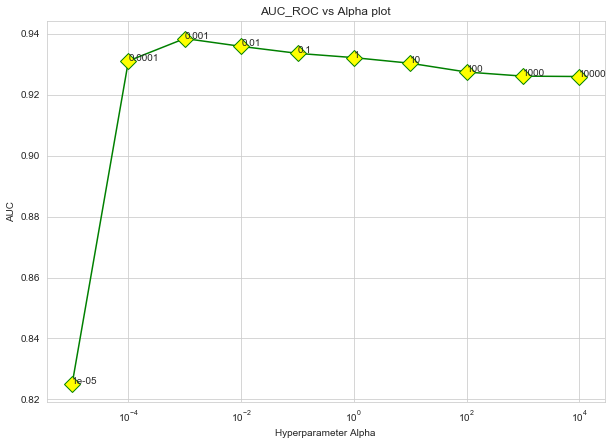

In [230]:
# plot of alpha vs auc_roc
plt.figure(figsize = (10,7))

sns.set_style("whitegrid");

plt.plot(alpha_list, cv_list, color='green',  marker='D',markerfacecolor='yellow', markersize=12)
ind=0
for val in alpha_list:
    plt.annotate('%s' % val,xy=(val,cv_list[ind]),xycoords='data')
    ind=ind+1
plt.xscale('log')
plt.title("AUC_ROC vs Alpha plot")
plt.xlabel('Hyperparameter Alpha')
plt.ylabel('AUC')
plt.show()

In [235]:
# optimal alpha
print(cv_list)
opt_alpha=cv_list.index(max(cv_list))
opt_alpha=math.pow(10,opt_alpha)*math.pow(10,-5)
print("Maximum auc is: ",max(cv_list),"for alpha=",opt_alpha)

[0.8249101627071955, 0.9311544597396937, 0.9385064631597126, 0.935922413393184, 0.9336320509328331, 0.9322290355806105, 0.9303841795337362, 0.9274967502158299, 0.9261496457288008, 0.9260263362319895]
Maximum auc is:  0.9385064631597126 for alpha= 0.001


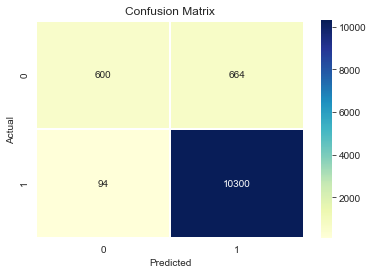

In [236]:
# print(metrics.confusion_matrix(y_test, predicted))

import seaborn as sb
from sklearn.metrics import confusion_matrix
log_optimal = LogisticRegression(penalty='l2',C=opt_alpha) 
log_optimal.fit(X_train, y_train)

conf_matrix = confusion_matrix(y_test,log_optimal.predict(X_test))
df_cmatrix = pd.DataFrame(conf_matrix) #, columns=['Negative', 'Positive'])
sb.heatmap(df_cmatrix, annot=True, fmt='d',cmap="YlGnBu", linewidths=1.4)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## AUC CURVE

In [238]:

# calculating train_auc
from sklearn.metrics import roc_auc_score

cv_list=[]

train_auc_list=[]

alpha_list=[10 ** x for x in range(-5, 5)]
for alp in alpha_list:
    clf = LogisticRegression(penalty='l2',C=alp)
    clf.fit(X_train,y_train)
    probs = clf.predict_proba(X_train)
    probs = probs[:,1]
    train_auc = roc_auc_score(y_train, probs)
    train_auc_list.append(train_auc)

In [239]:

# calculating test_auc
from sklearn.metrics import roc_auc_score


cv_list=[]

test_auc_list=[]

alpha_list=[10 ** x for x in range(-5, 5)]
for alp in alpha_list:
    clf = LogisticRegression(penalty='l2',C=alp)
    clf.fit(X_train,y_train)
    probs = clf.predict_proba(X_test)
    probs = probs[:,1]
    test_auc = roc_auc_score(y_test, probs)
    test_auc_list.append(test_auc)


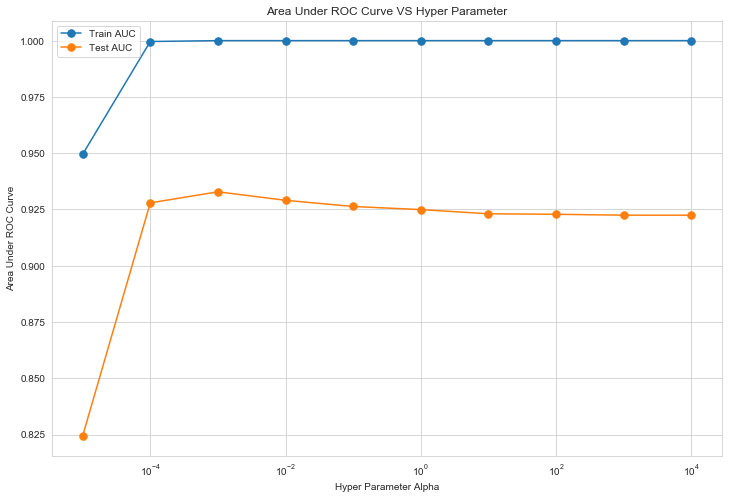

In [240]:

plt.figure(figsize = (12,8))
plt.plot(alpha_list, train_auc_list, marker='.',label="Train AUC",markersize=15)
plt.plot(alpha_list, test_auc_list, marker='.',label="Test AUC",markersize=15)

plt.xscale('log')

plt.legend()
plt.xlabel("Hyper Parameter Alpha")
plt.ylabel("Area Under ROC Curve")
plt.title("Area Under ROC Curve VS Hyper Parameter")
plt.show()

In [241]:
lr_optimal=LogisticRegression(penalty='l2',C=opt_alpha)
lr_optimal.fit(X_train,y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Train AUC: 1.000000
Test AUC: 0.932845


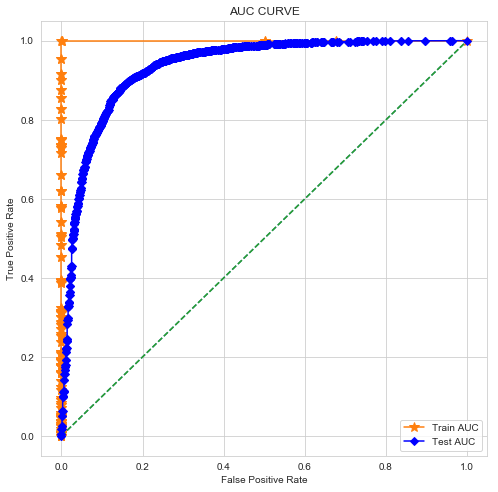

In [242]:

from matplotlib import pyplot
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

plt.figure(figsize = (8,8))
# predict probabilities
probs = lr_optimal.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
train_auc = roc_auc_score(y_train, probs)
print('Train AUC: %f' % train_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_train, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='*',label="Train AUC",markersize=10)


# predict probabilities
probs = lr_optimal.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
test_auc = roc_auc_score(y_test, probs)
print('Test AUC: %f' % test_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='D',color='blue',label="Test AUC",markersize=5)

plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC CURVE")

# show the plot
pyplot.show()




## Conclusion

In [243]:

tfidf_brute_par3=opt_alpha
tfidf_brute_auc3=np.round(test_auc,4)
print("Vectorizer: TFIDF with Summary and Text Combined \t Model: Logistic Regression")
print("Best Hyper parameter: ",tfidf_brute_par3)
print("AUC: ",tfidf_brute_auc3)


Vectorizer: TFIDF with Summary and Text Combined 	 Model: Logistic Regression
Best Hyper parameter:  0.001
AUC:  0.9328


# [6] Conclusions

In [244]:
# Please compare all your models using Prettytable library

In [254]:
# Constructing a table to summerize all the above results

from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", " Hyper Parameter  ", "AUC"]

x.add_row(["BOW", "Logistic Regression L1", bow_brute_par1, bow_brute_auc1])
x.add_row(["BOW", "Logistic Regression L2", bow_brute_par2, bow_brute_auc2])
x.add_row(["TFIDF", "Logistic Regression L1", tfidf_brute_par1, tfidf_brute_auc1])
x.add_row(["TFIDF", "Logistic Regression L2", tfidf_brute_par2, tfidf_brute_auc2])
x.add_row(["TFIDF with Text & Summary", "Logistic Regression L2", tfidf_brute_par3, tfidf_brute_auc3])
x.add_row(["AVG W2V", "Logistic Regression L1", avgwv_brute_par1, avgwv_brute_auc1])
x.add_row(["AVG W2V", "Logistic Regression L2", avgwv_brute_par2, avgwv_brute_auc2])
x.add_row(["TFIDF W2V", "Logistic Regression L1", tfidfwv_brute_par1, tfidfwv_brute_auc1])
x.add_row(["TFIDF W2V", "Logistic Regression L2", tfidfwv_brute_par2, tfidfwv_brute_auc2])


print("="*100)
print('Conclusions'.center(100,' '))
print("="*100)
print(x.get_string(border=True, padding_width=3))

                                            Conclusions                                             
+-------------------------------+----------------------------+------------------------+------------+
|           Vectorizer          |           Model            |    Hyper Parameter     |    AUC     |
+-------------------------------+----------------------------+------------------------+------------+
|              BOW              |   Logistic Regression L1   |          0.1           |   0.9024   |
|              BOW              |   Logistic Regression L2   |          0.01          |   0.8698   |
|             TFIDF             |   Logistic Regression L1   |          0.1           |   0.9184   |
|             TFIDF             |   Logistic Regression L2   |         0.001          |   0.9058   |
|   TFIDF with Text & Summary   |   Logistic Regression L2   |         0.001          |   0.9328   |
|            AVG W2V            |   Logistic Regression L1   |          1.0           |   0

## <font color='orange'>References</font>

1. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
2. https://machinelearningmastery.com/make-predictions-scikit-learn/
3. https://machinelearningmastery.com/sparse-matrices-for-machine-learning/
4. https://stackoverflow.com/questions/50879915/how-to-split-data-using-time-based-in-test-and-train-respectively
5. https://stackoverflow.com/questions/773814/plot-logarithmic-axes-with-matplotlib-in-python